<a href="https://colab.research.google.com/github/omerbokobza/DeepSuperResolution/blob/main/CROPPED_VDSRTransformerL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
import random
import torch.nn.functional as F
!pip install kornia
import kornia
import torchvision.transforms as T

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
import torchvision.models as models

# Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Downloading the data**

In [4]:
!mkdir DIV2K
!wget -O DIV2K/DIV2K_train_HR.zip http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K/DIV2K_train_HR.zip -d DIV2K

--2024-08-26 23:41:11--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-08-26 23:41:12--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K/DIV2K_train_HR.zip’

DIV2K/DIV2K_train_H 100%[===================>]   3.29G  22.6MB/s    in 2m 38s  

2024-08-26 23:43:51 (21.3 MB/s) - ‘DIV2K/DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K/DIV2K_train_HR.zip
   creating: DIV2K/DIV2K_train_HR/
  inflating: DIV2K/DIV2K_train_HR/

In [5]:
!wget -O DIV2K/DIV2K_valid_HR.zip http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
!unzip DIV2K/DIV2K_valid_HR.zip -d DIV2K

--2024-08-26 23:44:28--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2024-08-26 23:44:29--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K/DIV2K_valid_HR.zip’

DIV2K/DIV2K_valid_H 100%[===================>] 428.19M  21.9MB/s    in 21s     

2024-08-26 23:44:51 (20.3 MB/s) - ‘DIV2K/DIV2K_valid_HR.zip’ saved [448993893/448993893]

Archive:  DIV2K/DIV2K_valid_HR.zip
   creating: DIV2K/DIV2K_valid_HR/
  inflating: DIV2K/DIV2K_valid_HR/089

In [6]:
# List files in the DIV2K_train_HR directory
hr_dir = 'DIV2K/DIV2K_train_HR/'
print(os.listdir(hr_dir)[:10])  # Show the first 10 files

['0617.png', '0775.png', '0518.png', '0049.png', '0211.png', '0043.png', '0054.png', '0167.png', '0742.png', '0458.png']


In [7]:
# Set up paths for training and validation directories
train_hr_dir = 'DIV2K/DIV2K_train_HR/'
valid_hr_dir = 'DIV2K/DIV2K_valid_HR/'

#splitting & visualize the data

In [8]:
train_images = os.listdir(train_hr_dir)
val_images = os.listdir(valid_hr_dir)
print(f'Train Before Splitting: {len(train_images)}')

test_images = random.sample(train_images, 100)
train_images = [img for img in train_images if img not in test_images]

print(f'Train After Split: {len(train_images)}, Test: {len(test_images)}, Validation: {len(val_images)}')

Train Before Splitting: 800
Train After Split: 700, Test: 100, Validation: 100


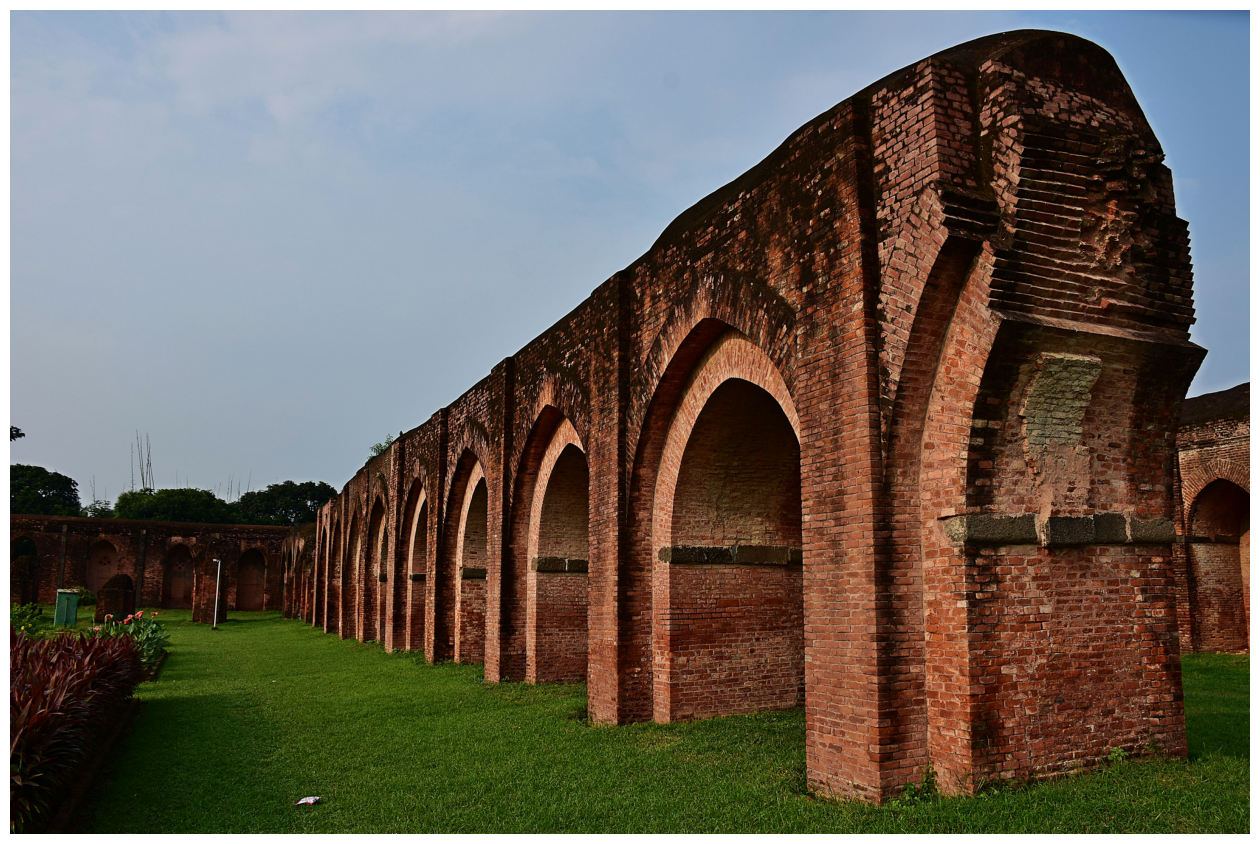

In [9]:
# Load an example image
example_image_path = os.path.join(hr_dir, '0283.png')  # Change the filename as needed
image = Image.open(example_image_path)

# Display the image
plt.figure(figsize=(16, 16))
plt.imshow(image)
plt.axis('off')  # Hide axis labels
plt.show()

In [10]:
print(image.size)

(2040, 1356)


In [9]:
class DIV2KDataset(Dataset):
    def __init__(self, image_list, hr_dir, crop_size=(256, 256), scale_factor=4, transform=None):
        super(DIV2KDataset, self).__init__()
        self.image_list = image_list
        self.hr_dir = hr_dir
        self.crop_size = crop_size
        self.scale_factor = scale_factor
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load the high-resolution image
        image_path = os.path.join(self.hr_dir, self.image_list[idx])
        image = Image.open(image_path).convert('RGB')

        if image.size[0] < image.size[1]:
            image = image.rotate(-90, expand=True)

        # Random crop to the crop_size (e.g., 256x256)
        hr_image = transforms.RandomCrop(self.crop_size)(image)

        # Resize HR image to low-resolution (e.g., 64x64)
        lr_image = hr_image.resize((self.crop_size[0] // self.scale_factor, self.crop_size[1] // self.scale_factor), Image.BICUBIC)

        # Apply transformations
        hr_image = self.transform(hr_image)
        lr_image = self.transform(lr_image)

        return lr_image, hr_image

In [47]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create datasets
crop_size = (128, 128)
scale_factor = 4

train_dataset = DIV2KDataset(train_images, train_hr_dir, crop_size=crop_size, scale_factor=scale_factor, transform=transform)
valid_dataset = DIV2KDataset(os.listdir(valid_hr_dir), valid_hr_dir, crop_size=crop_size, scale_factor=scale_factor, transform=transform)
test_dataset = DIV2KDataset(test_images, train_hr_dir, crop_size=crop_size, scale_factor=scale_factor, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [48]:
for lr_imgs, hr_imgs in train_loader:
    print(f"Low-resolution images batch shape: {lr_imgs.shape}")
    print(f"High-resolution images batch shape: {hr_imgs.shape}")
    break


Low-resolution images batch shape: torch.Size([16, 3, 32, 32])
High-resolution images batch shape: torch.Size([16, 3, 128, 128])


Low-resolution image size: (32, 32)
High-resolution image size: (128, 128)


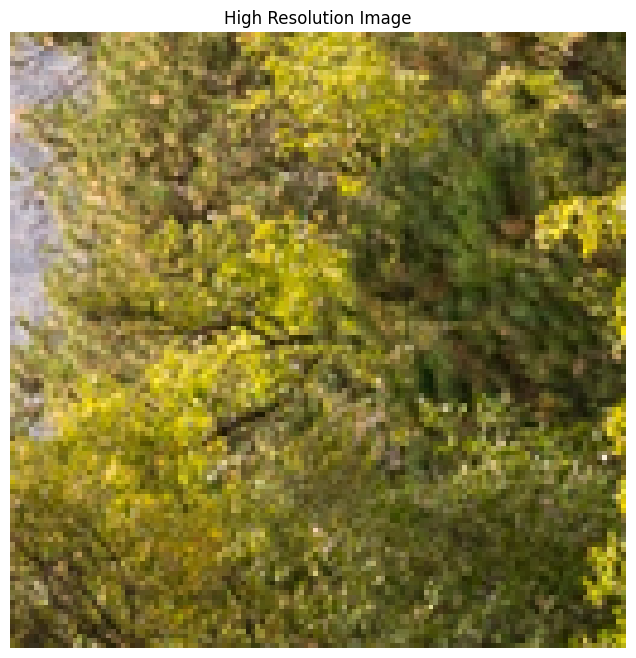

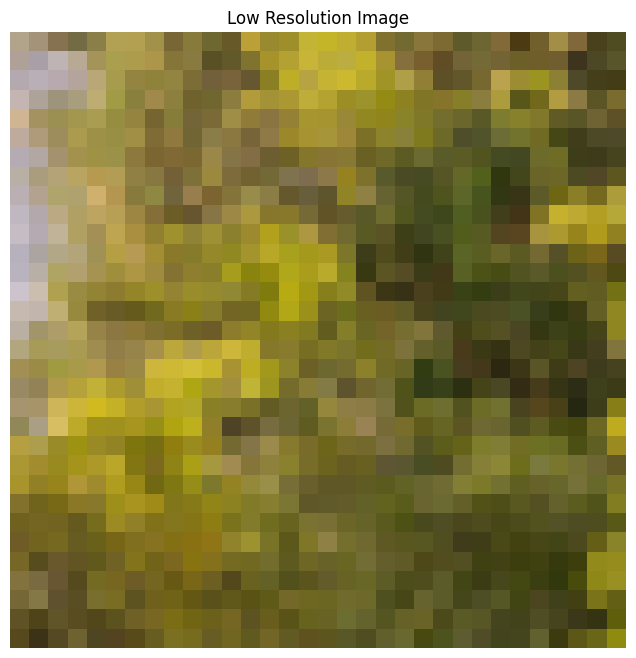

In [23]:
# Define the inverse normalization transformation
inverse_transform = transforms.Compose([
    transforms.Normalize((-1, -1, -1), (2, 2, 2)),  # Undo the normalization
    transforms.ToPILImage()  # Convert back to a PIL image
])

# Assuming lr_image and hr_image are from the DataLoader
for lr_images, hr_images in train_loader:
    # Take the first image from the batch
    lr_image = lr_images[0]
    hr_image = hr_images[0]
    #
    # Un-normalize and convert to PIL image
    lr_image_pil = inverse_transform(lr_image)
    hr_image_pil = inverse_transform(hr_image)

    # Display the images
    print(f"Low-resolution image size: {lr_image_pil.size}")
    print(f"High-resolution image size: {hr_image_pil.size}")

    plt.figure(figsize=(8, 8))
    plt.title("High Resolution Image")
    plt.imshow(hr_image_pil)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.title("Low Resolution Image")
    plt.imshow(lr_image_pil)
    plt.axis('off')
    plt.show()

    break  # Display only the first batch


# VDSR-Transformer Model for Super-Resolution


## Explanation

### Introduction
The VDSR-Transformer model combines the strengths of Very Deep Super Resolution (VDSR) networks and Transformer-based architectures to enhance image resolution, particularly in cases where fine details and global context are important.

## VDSR (Very Deep Super Resolution)

### Role
The VDSR part of the model is responsible for learning and reconstructing high-frequency details that are typically lost in low-resolution images. It is a convolutional neural network (CNN) with a deep architecture designed specifically for super-resolution tasks.

### Components
- **Initial Convolution Layer**: Extracts low-level features from the input image.
- **ReLU Activation**: Introduces non-linearity to the model, helping it learn complex patterns.
- **Multiple Convolutional Layers**: Stacks of convolutional layers with ReLU activation allow the model to learn hierarchical features, from basic edges to more complex textures and patterns.
- **Final Convolution Layer**: Outputs a feature map that represents the reconstructed high-resolution image before any additional processing.

### Strengths
- **Detail Preservation**: VDSR is particularly good at preserving fine details, such as edges and textures.
- **Residual Learning**: VDSR typically employs residual learning, which helps in speeding up training and improving the stability of deeper networks by focusing on learning the difference (residual) between the low-resolution input and the high-resolution output.

## Transformer Block

### Role
The Transformer block is integrated into the model to capture long-range dependencies and global context in the image. While CNNs are excellent at capturing local features, Transformers excel at understanding relationships across the entire image, making them a powerful addition to the super-resolution task.

### Components
- **Attention Mechanism**: The core of the Transformer is the attention mechanism, which allows the model to weigh the importance of different parts of the image when constructing the high-resolution output. This is crucial for tasks where global context matters, such as in images with complex structures.
- **Feedforward Neural Network**: After the attention mechanism, a small feedforward neural network helps refine the features by applying additional transformations.

### Strengths
- **Global Context Awareness**: Transformers can capture relationships between distant parts of an image, which is particularly useful in scenes where context plays a significant role in the visual content.
- **Versatility**: Transformers can adapt to different scales and types of patterns in the image, making the model more robust across various types of images.

## Combined VDSR-Transformer Model

### Role
The combination of VDSR and Transformer blocks leverages the strengths of both approaches to produce high-quality super-resolution images. The VDSR part ensures that local details are preserved and enhanced, while the Transformer part ensures that the model is aware of and can leverage global patterns and context across the image.

### Flow of Data
1. **Input Image (64x128)**: The process starts with a low-resolution image.
2. **Initial Convolution Layer**: Extracts initial features from the image.
3. **ReLU Activation**: Introduces non-linearity.
4. **Sequential Convolution Layers**: These layers, with ReLU activations, process the image to extract progressively more complex features.
5. **Transformer Block**: The processed features are passed through a Transformer block to incorporate global context and relationships.
6. **Convolution Layer**: Further refines the features after the Transformer block.
7. **Upsampling Layer**: Doubles the resolution of the image, scaling the dimensions from 64x128 to 128x256.
8. **Final Convolution Layer**: Produces the final high-resolution output.
9. **Output Image (128x256)**: The final super-resolved image.

## Conclusion
The VDSR-Transformer model is designed to excel in scenarios where both local details and global context are important. The VDSR component ensures that fine details are accurately reconstructed, while the Transformer block adds the capability to understand and incorporate information from across the entire image, leading to a more accurate and visually pleasing high-resolution output. This combination makes the model highly effective for a variety of super-resolution tasks.


## Model-Code

In [46]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height * width)  # Flatten spatial dimensions
        x = x.permute(2, 0, 1).contiguous()  # (sequence_length, batch_size, embed_dim)

        x = self.norm1(x)
        x, _ = self.attn(x, x, x)

        x = x + self.mlp(self.norm2(x))

        x = x.permute(1, 2, 0).contiguous()  # (batch_size, embed_dim, sequence_length)
        x = x.view(batch_size, channels, height, width)  # Restore spatial dimensions
        return x

class VDSRWithTransformer(nn.Module):
    def __init__(self, num_layers=18, num_heads=8):
        super(VDSRWithTransformer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

        self.transformer = TransformerBlock(dim=64, num_heads=num_heads)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.layers(x)
        x = self.transformer(x)
        x = self.conv2(x)
        x = self.upsample(x)  # Upsample the feature maps by a factor of 2
        x = self.conv3(x)
        return x

# model = VDSRWithTransformer()
# input_tensor_128 = torch.rand(1, 3, 64, 64)  # Batch size of 1, 3 channels (RGB), 64x128 image
# output_128 = model(input_tensor_128)
# print(f"Input size: {input_tensor_128.shape}, Output size: {output_128.shape}")



In [14]:
def save_checkpoint(model, epoch, val_loss, name_for_checkpoints, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_filename = f'{name_for_checkpoints}_epoch_{epoch+1}_val_loss_{val_loss:.4f}.pth'
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [15]:
torch.cuda.empty_cache()

In [31]:
def train_vdsr(model, train_loader, valid_loader, criterion, perceptual_criterion, optimizer, num_epochs=20, device='cuda', name_for_checkpoints=None, checkpoint_dir='/content/gdrive/My Drive/Colab Notebooks/checkpoints'):
    model = model.to(device)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}...')

        # Training Phase
        model.train()
        train_loss = 0.0

        for lr_imgs, hr_imgs in train_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            optimizer.zero_grad()

            # Generate high-resolution images from low-resolution images
            fake_hr_imgs = model(lr_imgs)

            # Content loss (e.g., Mean Squared Error between generated and real HR images)
            loss = criterion(fake_hr_imgs, hr_imgs)
            # perceptual_loss = perceptual_criterion(fake_hr_imgs, hr_imgs)
            # loss = loss + 0.01 * perceptual_loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for lr_imgs, hr_imgs in valid_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                fake_hr_imgs = model(lr_imgs)
                val_loss += criterion(fake_hr_imgs, hr_imgs).item()

        avg_val_loss = val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint every 4 epochs and at the first epoch
        if (epoch + 1) % 4 == 0 or epoch == 0:
            save_checkpoint(model, epoch, avg_val_loss, name_for_checkpoints, checkpoint_dir)

        torch.cuda.empty_cache()

    # Plot training and validation loss
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    plt.savefig('/content/gdrive/My Drive/Colab Notebooks/figs/{name_for_checkpoints}_loss.pdf', bbox_inches='tight')

    return model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#**LOSS = MAE= $\sum{|y_{out}-y_{in}|}$**

In [18]:
# class CombinedMSEMAELoss(nn.Module):
#     def __init__(self, alpha=0.5):
#         """
#         Combined MSE and MAE loss function.

#         Args:
#         - alpha (float): Regularization factor for the MAE term. Controls the influence of the MAE on the total loss.
#         """
#         super(CombinedMSEMAELoss, self).__init__()
#         self.mse = nn.MSELoss()
#         self.mae = nn.L1Loss()
#         self.alpha = alpha

#     def forward(self, output, target):
#         mse_loss = self.mse(output, target)
#         mae_loss = self.mae(output, target)
#         combined_loss = mse_loss + self.alpha * mae_loss
#         return combined_loss

class PerceptualLoss(nn.Module):
    def __init__(self, pretrained_model, device):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = nn.Sequential(*list(pretrained_model.features)[:16]).eval()  # Example: VGG layers till conv4_3
        self.feature_extractor = self.feature_extractor.to(device)

    def forward(self, output, target):
        output_features = self.feature_extractor(output)
        target_features = self.feature_extractor(target)
        loss = F.mse_loss(output_features, target_features)
        return loss
vgg16 = models.vgg16(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


Epoch 1/20...
Epoch [1/20], Train Loss: 0.3833
Epoch [1/20], Validation Loss: 0.3101
Checkpoint saved: /content/gdrive/My Drive/Colab Notebooks/checkpoints/vdsr_with_transformer_L2_64_epoch_1_val_loss_0.3101.pth
Epoch 2/20...
Epoch [2/20], Train Loss: 0.3277
Epoch [2/20], Validation Loss: 0.1563
Epoch 3/20...
Epoch [3/20], Train Loss: 0.2108
Epoch [3/20], Validation Loss: 0.1382
Epoch 4/20...
Epoch [4/20], Train Loss: 0.1945
Epoch [4/20], Validation Loss: 0.1463
Checkpoint saved: /content/gdrive/My Drive/Colab Notebooks/checkpoints/vdsr_with_transformer_L2_64_epoch_4_val_loss_0.1463.pth
Epoch 5/20...
Epoch [5/20], Train Loss: 0.1835
Epoch [5/20], Validation Loss: 0.1269
Epoch 6/20...
Epoch [6/20], Train Loss: 0.1579
Epoch [6/20], Validation Loss: 0.0953
Epoch 7/20...
Epoch [7/20], Train Loss: 0.1416
Epoch [7/20], Validation Loss: 0.0812
Epoch 8/20...
Epoch [8/20], Train Loss: 0.1284
Epoch [8/20], Validation Loss: 0.0885
Checkpoint saved: /content/gdrive/My Drive/Colab Notebooks/checkpo

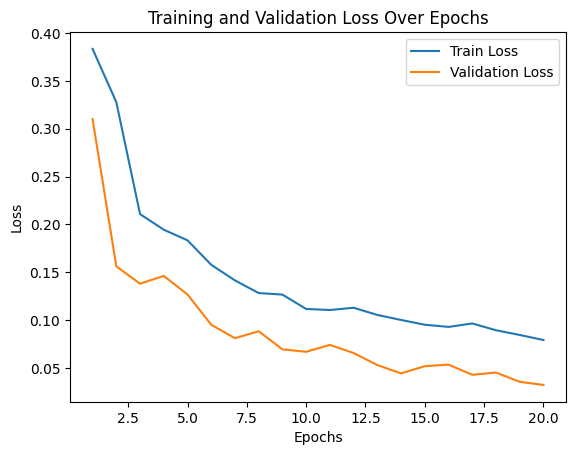

<Figure size 640x480 with 0 Axes>

In [49]:
# Instantiate the model, loss function, and optimizer
name_for_checkpoints = 'vdsr_with_transformer_L2_64'
model = VDSRWithTransformer()  # Assuming this is the VDSRWithTransformer model you defined
criterion = nn.MSELoss().to(device)
perceptual_criterion = PerceptualLoss(vgg16, device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Assuming train_loader and valid_loader are defined
trained_model = train_vdsr(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    perceptual_criterion=perceptual_criterion,
    optimizer=optimizer,
    num_epochs=20,
    device=device,
    name_for_checkpoints=name_for_checkpoints
)

# Evaluation

In [33]:
def calculate_psnr(output, target):
    mse = F.mse_loss(output, target)
    psnr = 10 * torch.log10(1 / mse)  # assuming images are normalized between [0, 1]
    return psnr.item()

In [34]:
def calculate_ssim(output, target):
    # SSIM expects images to be in range [0, 1]
    output = output.clamp(0, 1)
    target = target.clamp(0, 1)

    # Calculate SSIM
    ssim_value = kornia.metrics.ssim(output, target, window_size=11).mean()
    return ssim_value.item()

def gaussian(window_size, sigma, device):
    gauss = torch.tensor([torch.exp(torch.tensor(-(x - window_size//2)**2 / float(2*sigma**2))) for x in range(window_size)], device=device)
    return gauss / gauss.sum()

def create_window(window_size, channel, device):
    _1D_window = gaussian(window_size, 1.5, device).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=11, size_average=True):
    (_, channel, _, _) = img1.size()
    device = img1.device
    window = create_window(window_size, channel, device)

    return _ssim(img1, img2, window, window_size, channel, size_average)

def msssim(img1, img2, window_size=11, size_average=True):
    weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(img1.device)
    levels = weights.size()[0]
    mssim = []

    for _ in range(levels):
        ssim_map = ssim(img1, img2, window_size, size_average)
        mssim.append(ssim_map)

        if img1.size(2) == 1 or img1.size(3) == 1:
            break

        img1 = F.avg_pool2d(img1, (2, 2))
        img2 = F.avg_pool2d(img2, (2, 2))

    mssim = torch.stack(mssim)
    return (mssim * weights).sum()


In [50]:
def evaluate_model_with_mssim(model, test_loader, device='mps'):
    model.eval()
    avg_psnr = 0.0
    avg_ssim = 0.0
    avg_mssim = 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            outputs = model(lr_imgs)

            # Calculate PSNR, SSIM, and MSSIM
            psnr_value = calculate_psnr(outputs, hr_imgs)
            ssim_value = calculate_ssim(outputs, hr_imgs)
            mssim_value = msssim(outputs, hr_imgs)

            avg_psnr += psnr_value
            avg_ssim += ssim_value
            avg_mssim += mssim_value

    avg_psnr /= num_batches
    avg_ssim /= num_batches
    avg_mssim /= num_batches

    print(f'Average PSNR: {avg_psnr:.4f} dB')
    print(f'Average SSIM: {avg_ssim:.4f}')
    print(f'Average MSSIM: {avg_mssim:.4f}')

    return avg_psnr, avg_ssim, avg_mssim

# Evaluate your trained model on the test set
evaluate_model_with_mssim(trained_model, test_loader, device=device)


Average PSNR: 14.5810 dB
Average SSIM: 0.7014
Average MSSIM: 0.7116


(14.581043924604144, 0.7013774173600333, tensor(0.7116, device='cuda:0'))

In [ ]:
model = VDSRWithTransformer()
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/checkpoints/vdsr_with_transformer_L1_epoch_20_val_loss_0.2301.pth'
model.load_state_dict(torch.load(checkpoint_path))

# Step 3: Move the model to the device
model = model.to(device)
evaluate_model_with_mssim(model, test_loader, device=device)

Average PSNR: 12.4308 dB
Average SSIM: 0.5722
Average MSSIM: 0.6263


(12.43078054700579, 0.5721685801233564, tensor(0.6263, device='cuda:0'))

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


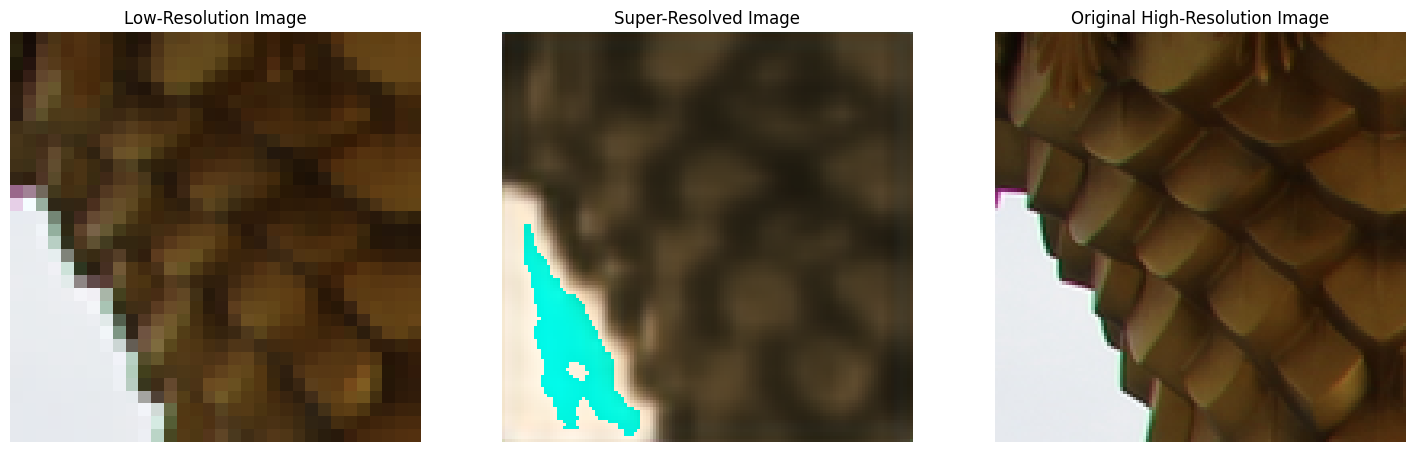

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


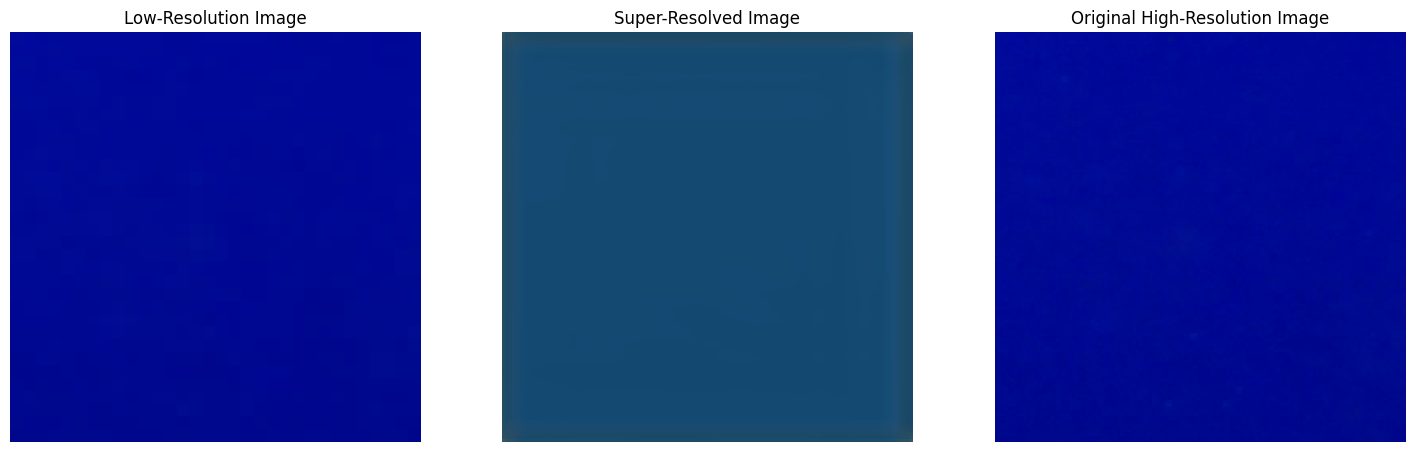

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


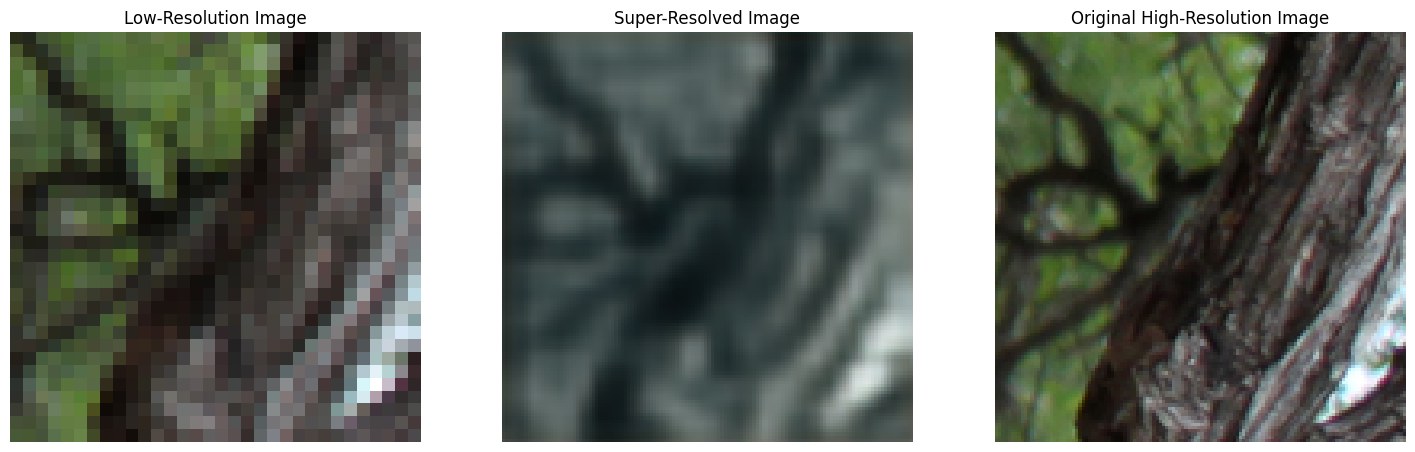

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


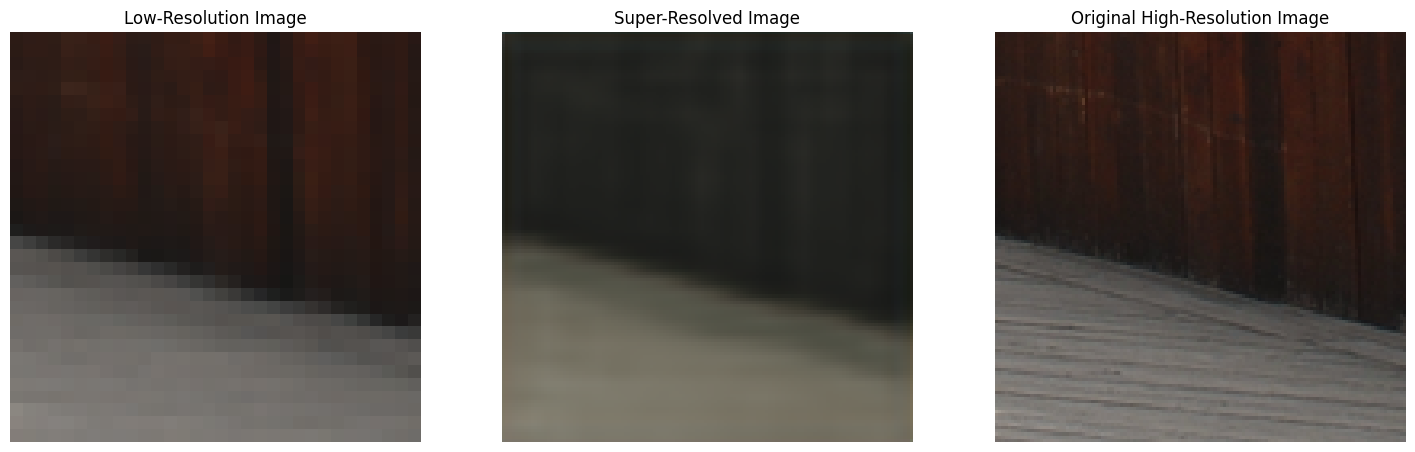

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


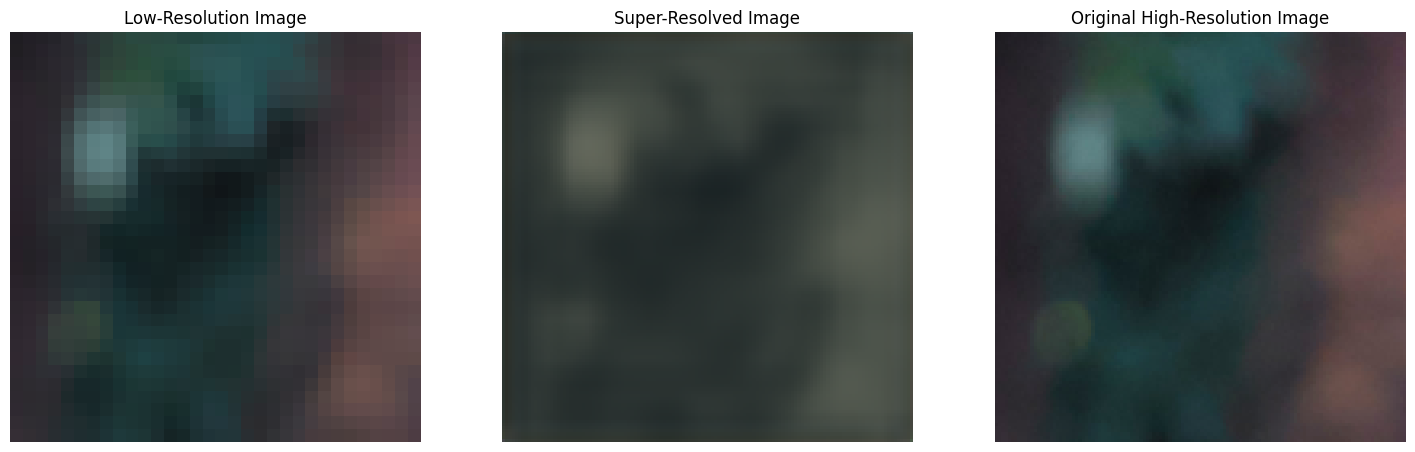

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


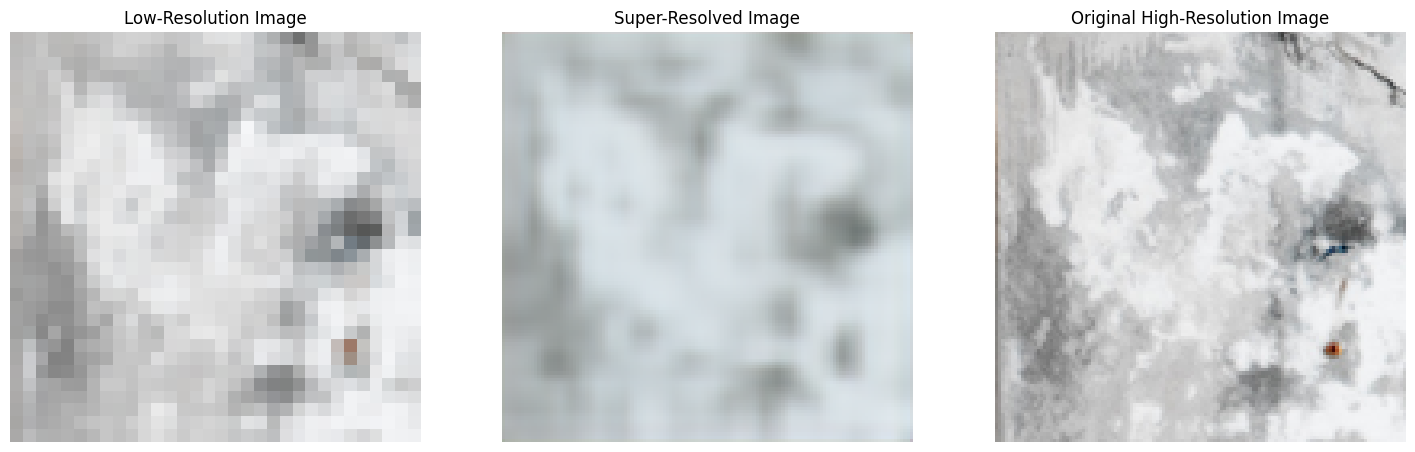

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


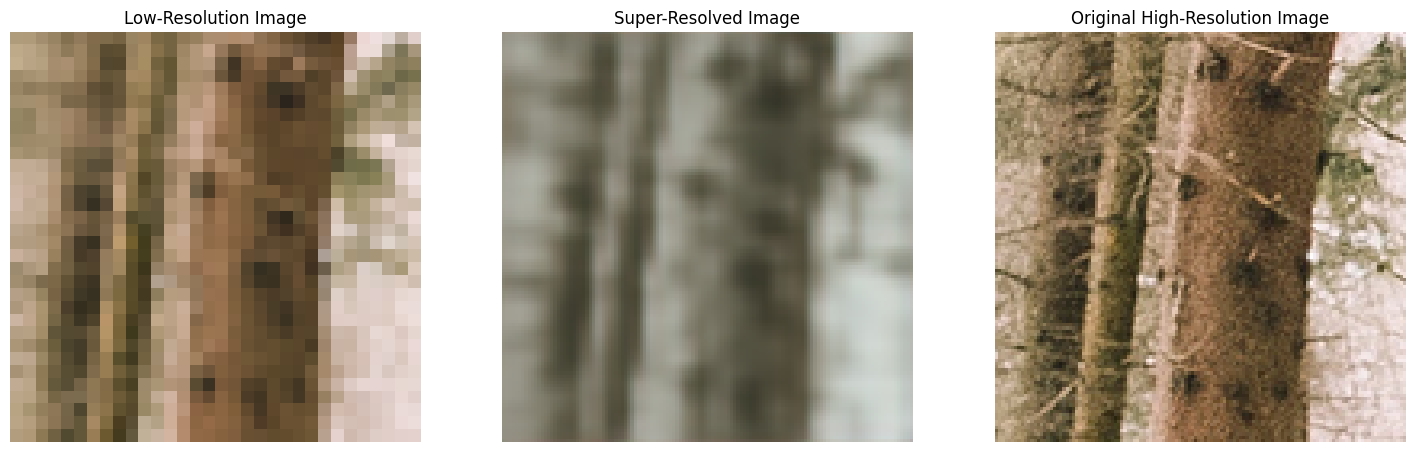

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


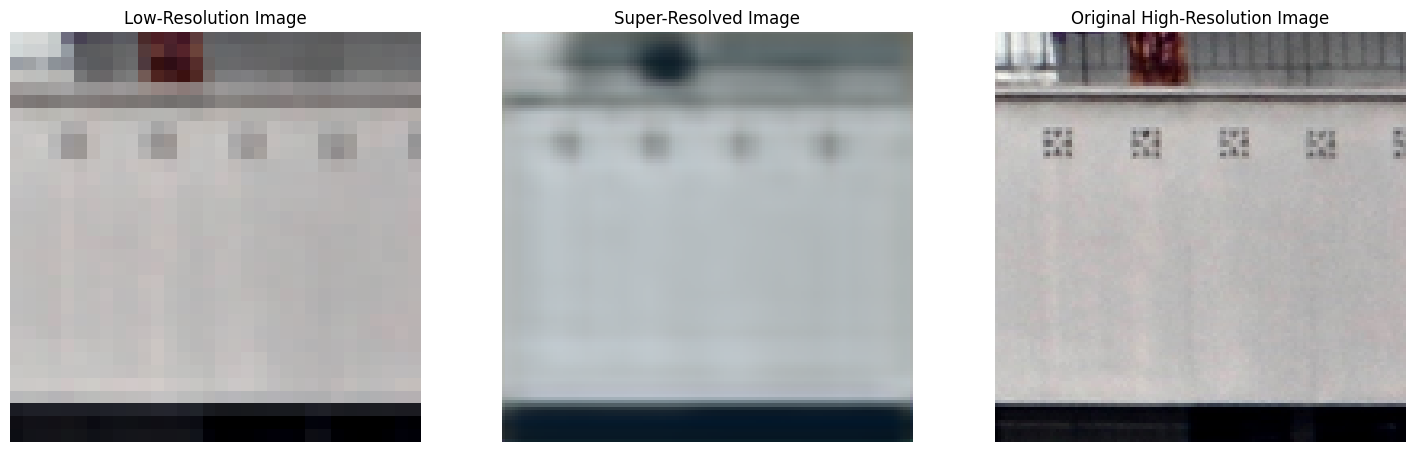

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


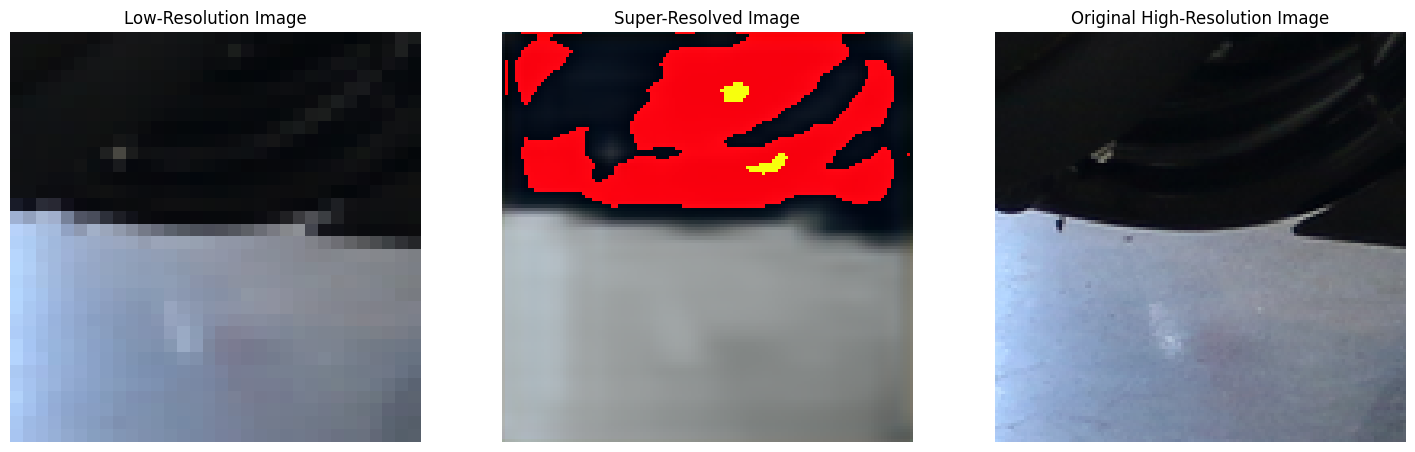

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


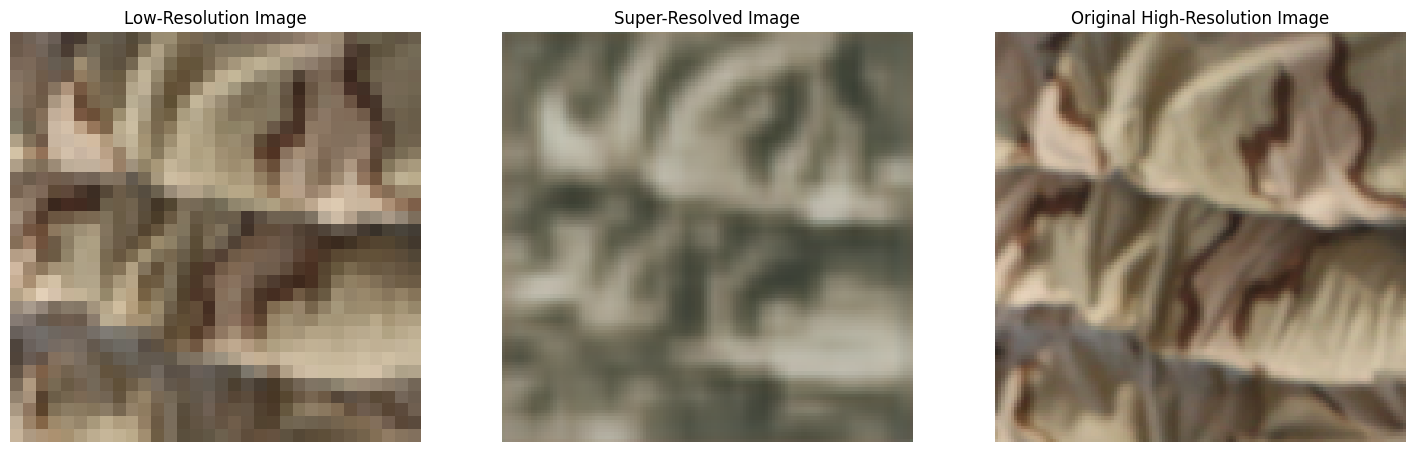

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


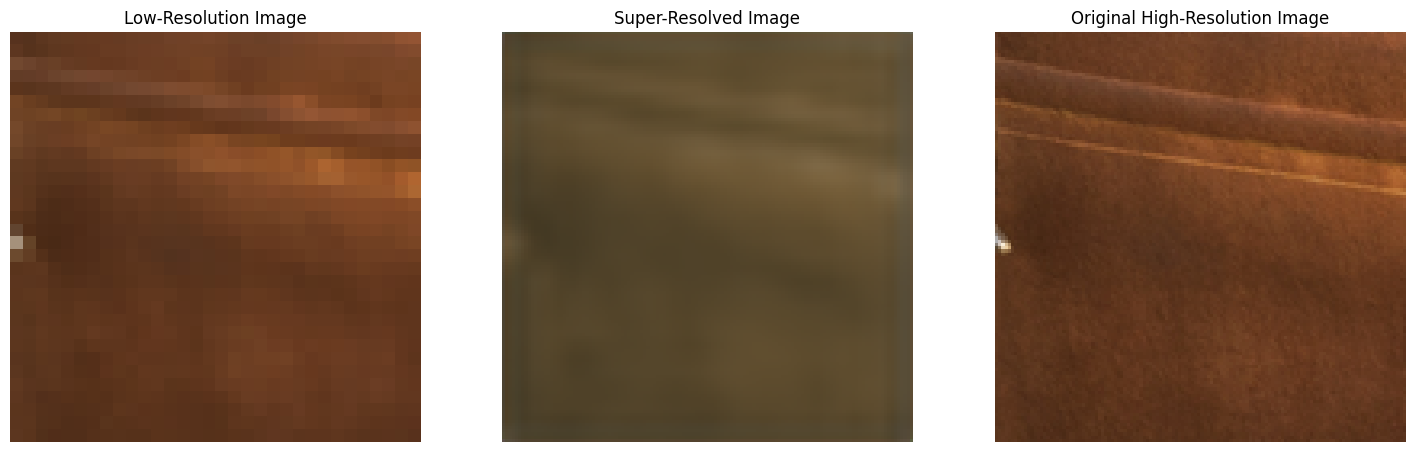

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


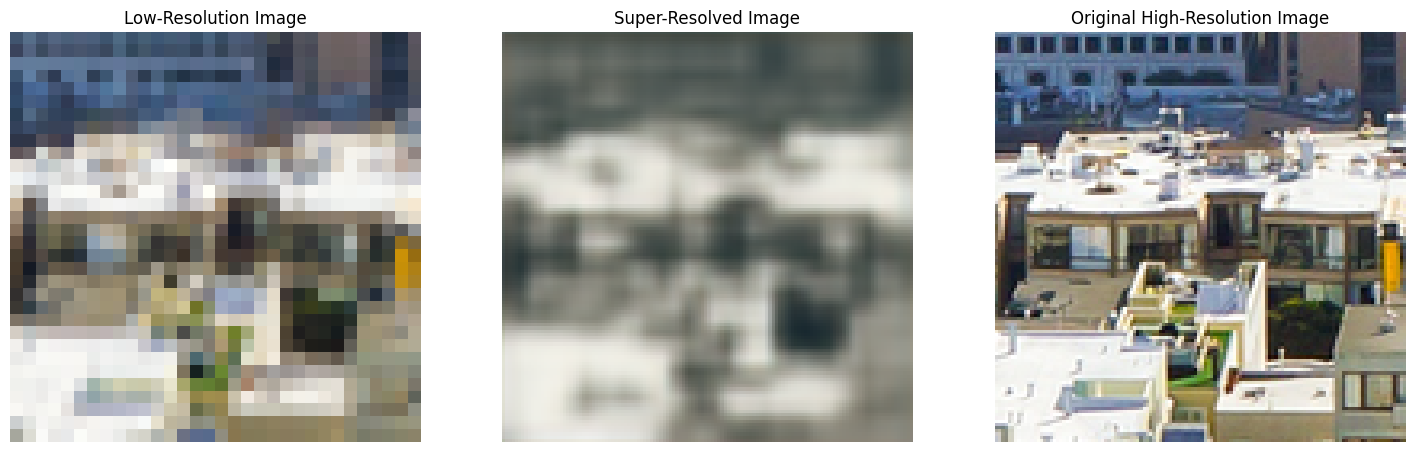

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


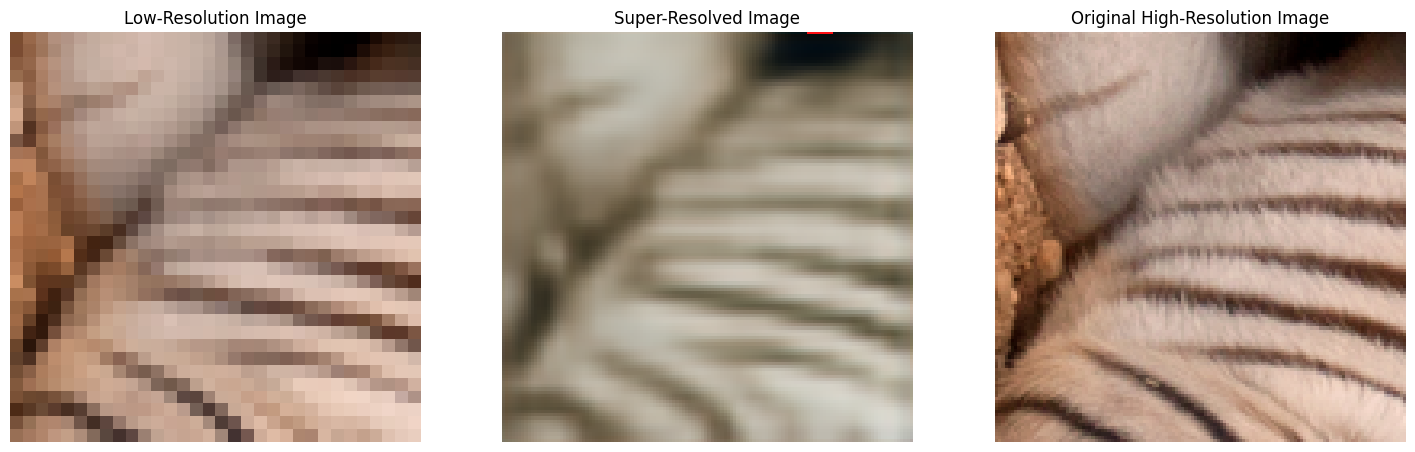

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


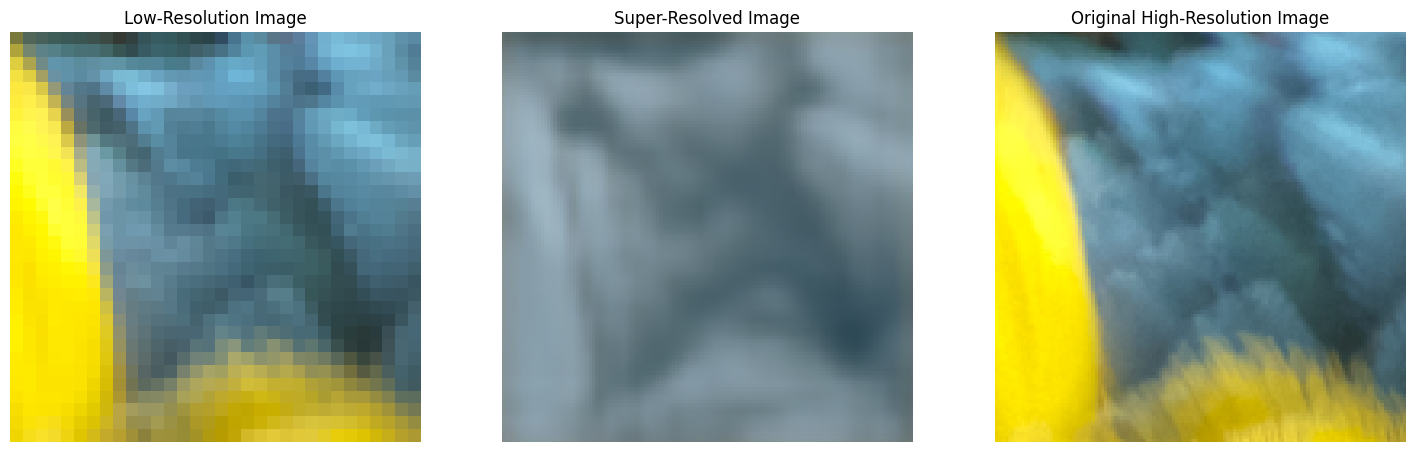

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


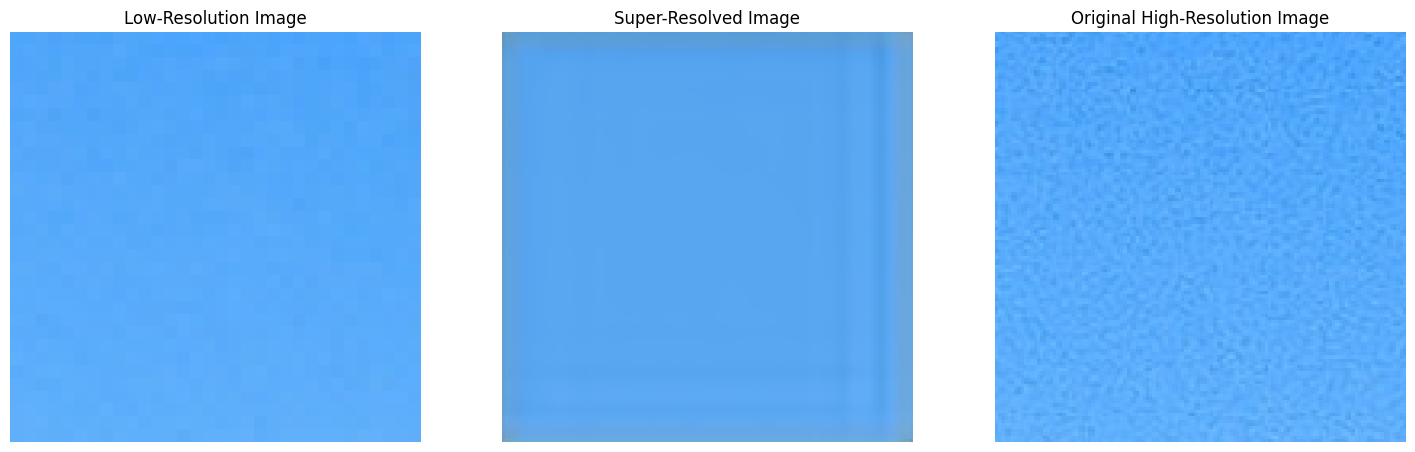

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


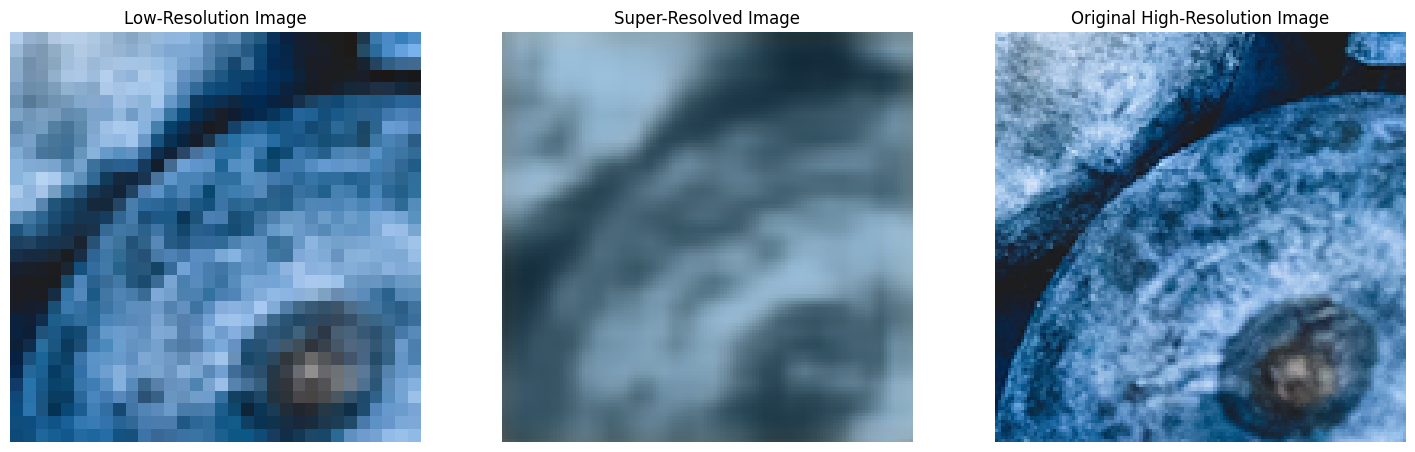

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


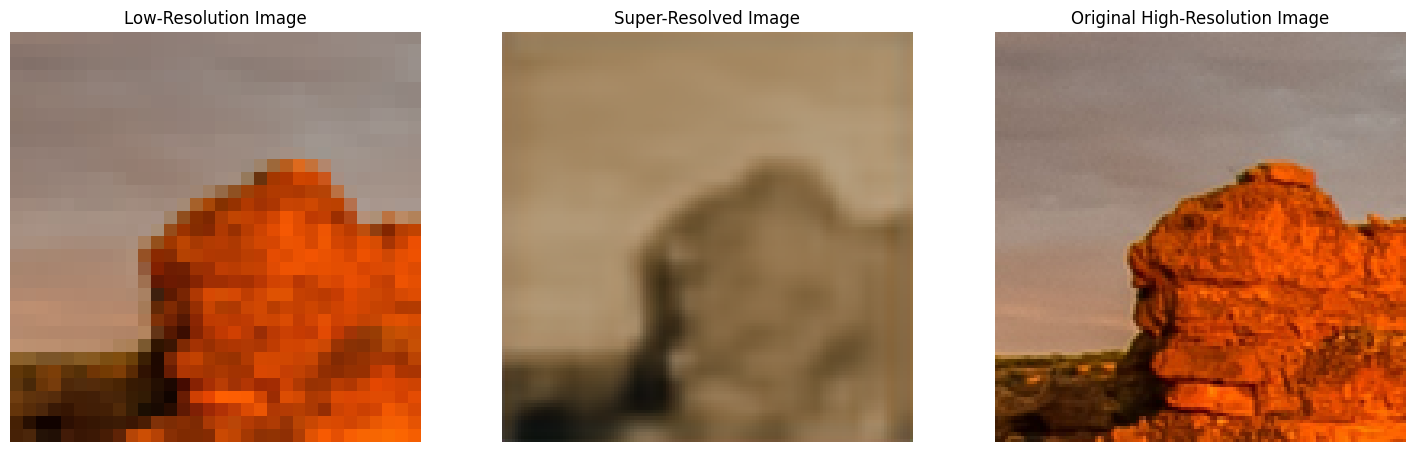

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


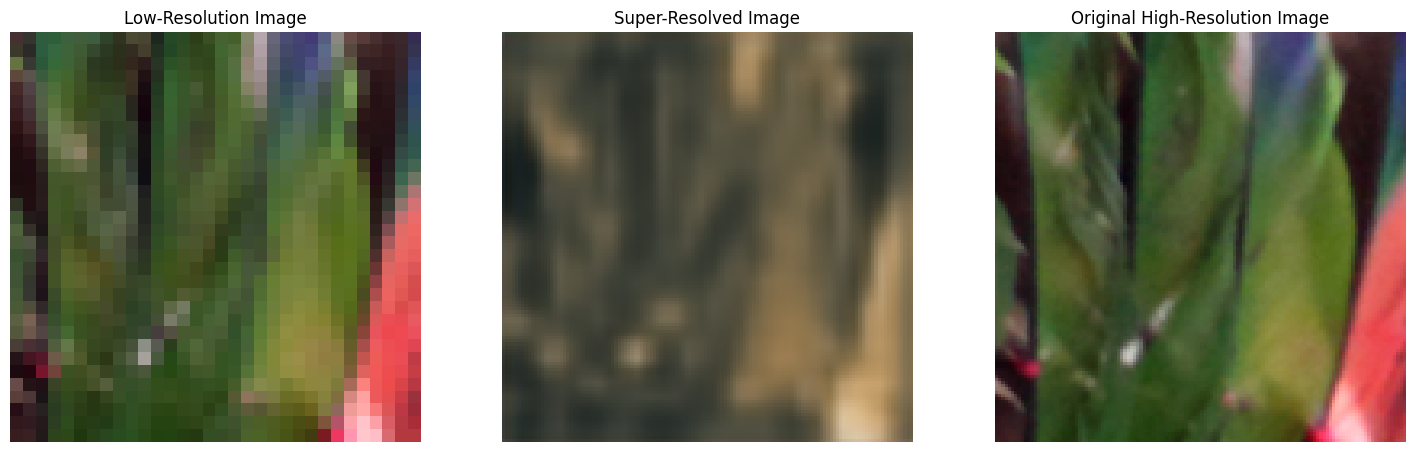

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


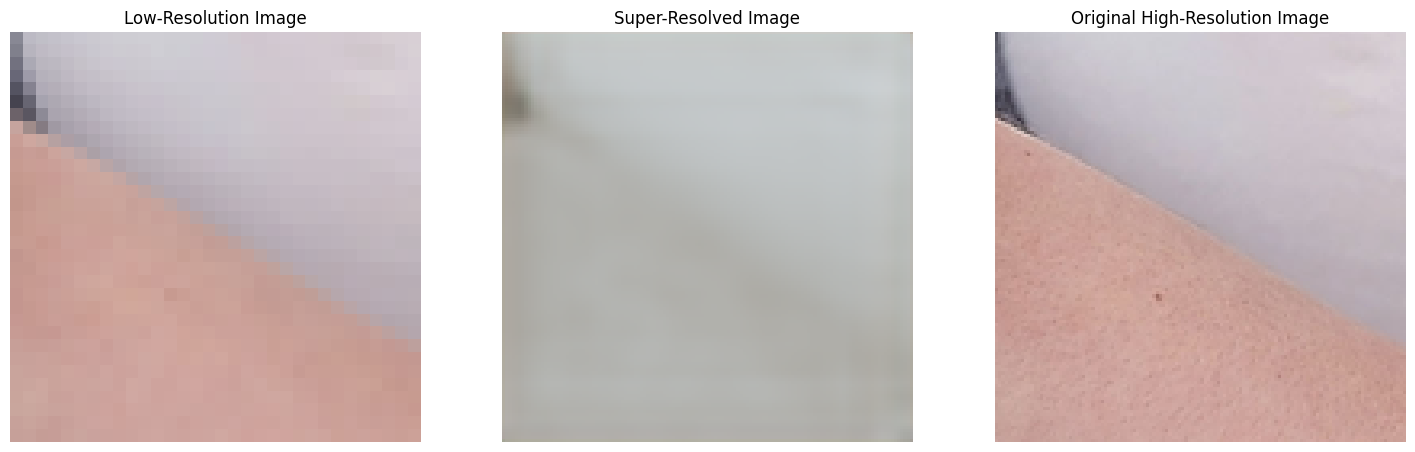

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


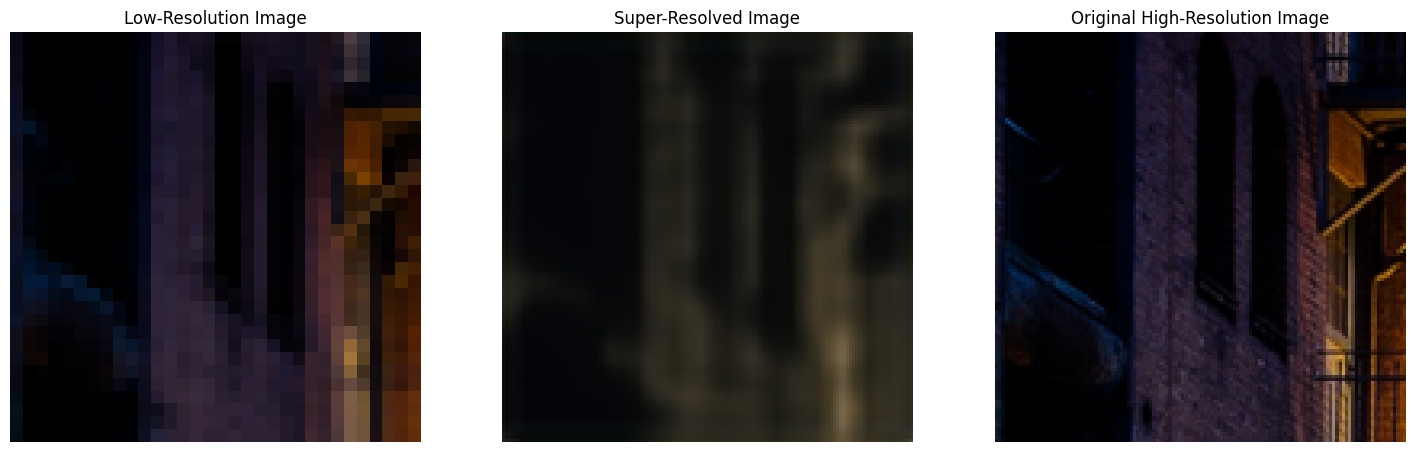

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


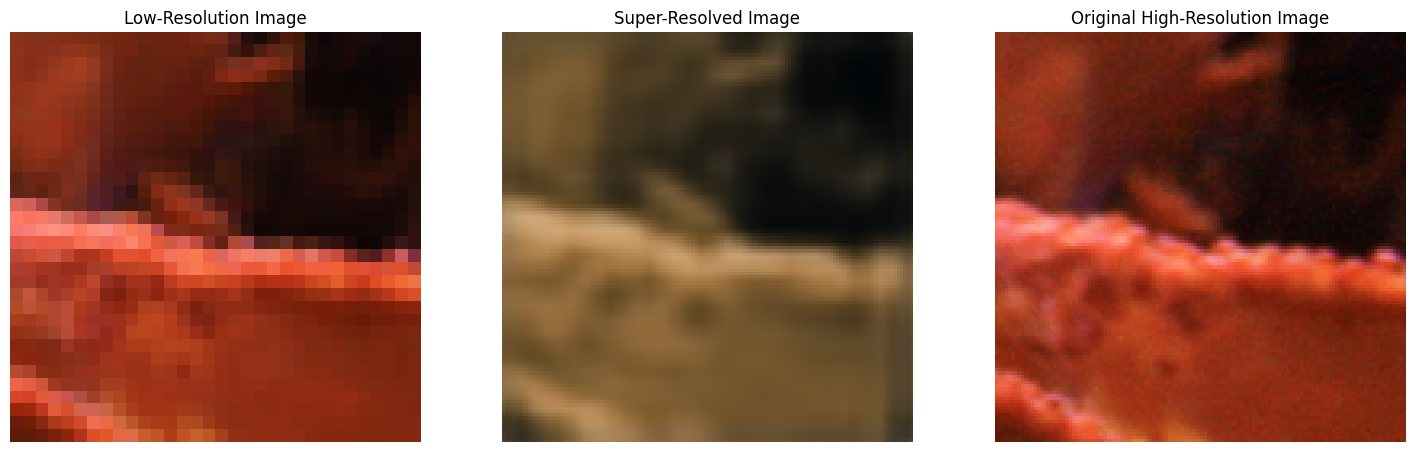

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


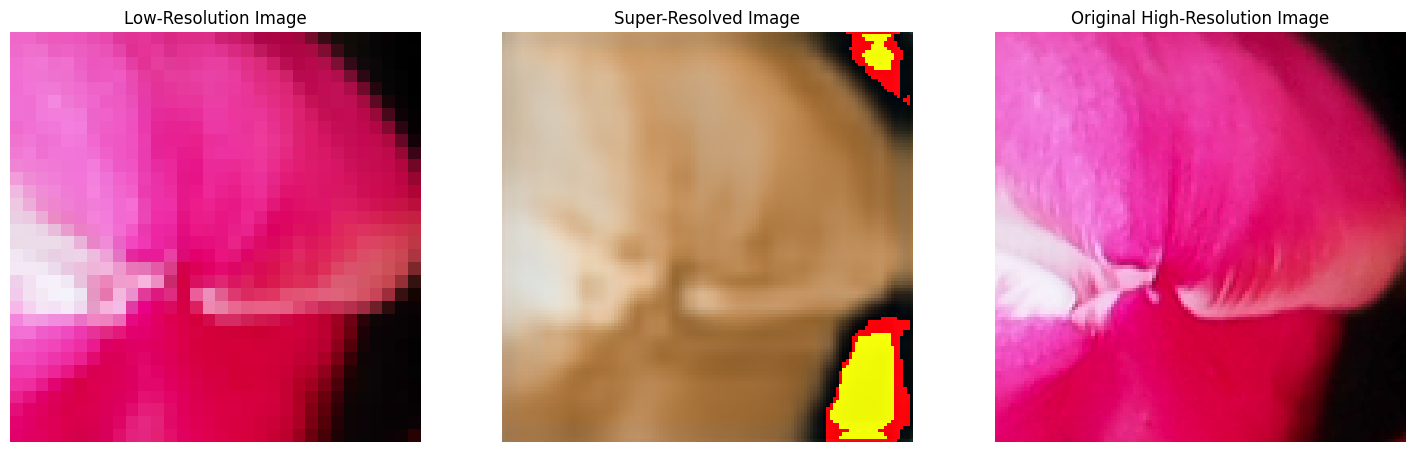

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


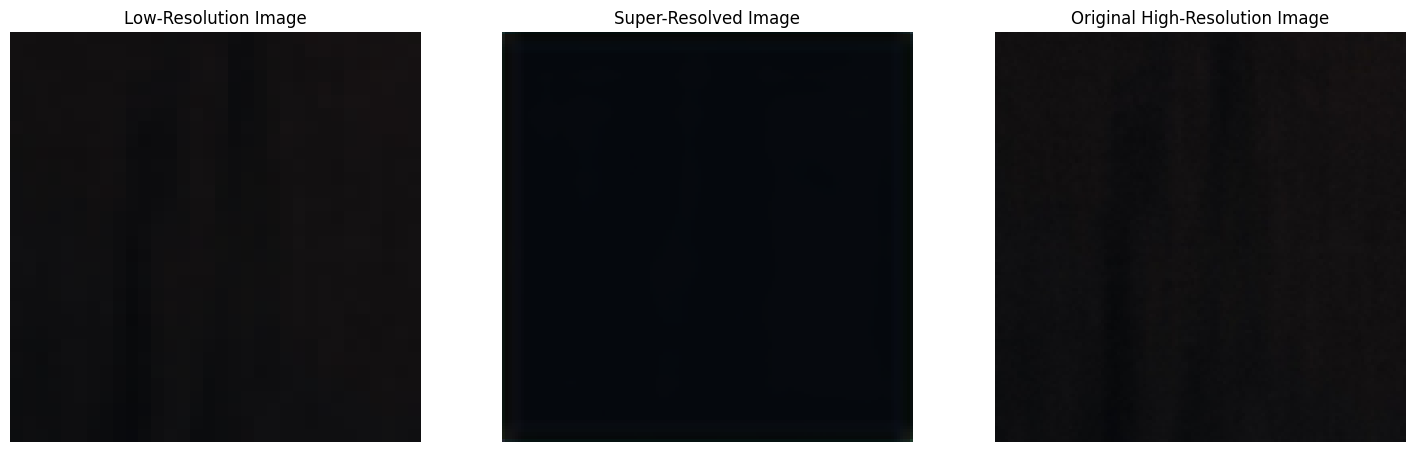

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


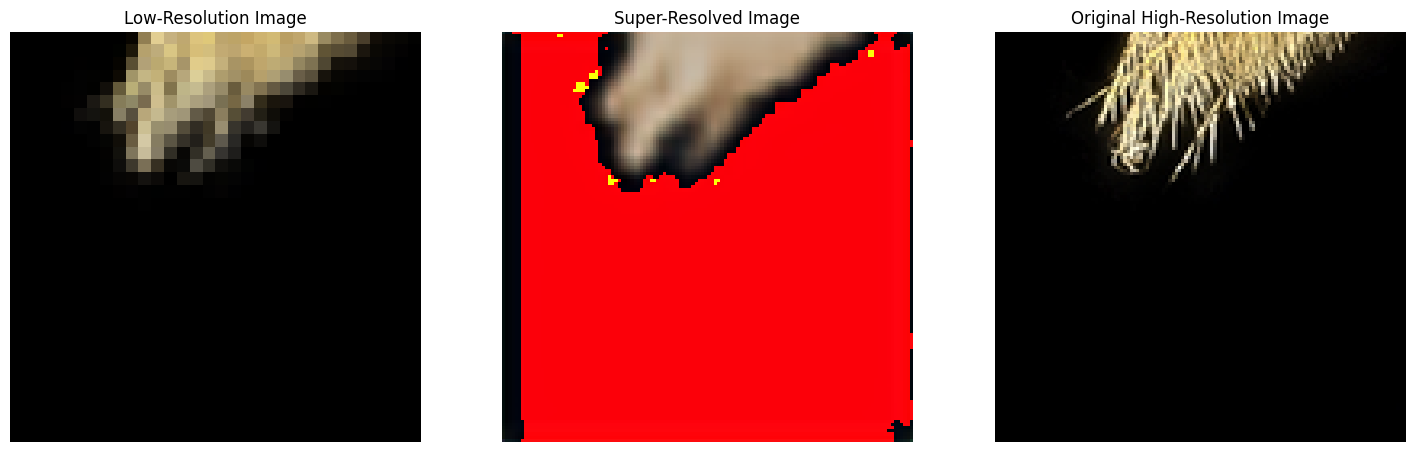

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


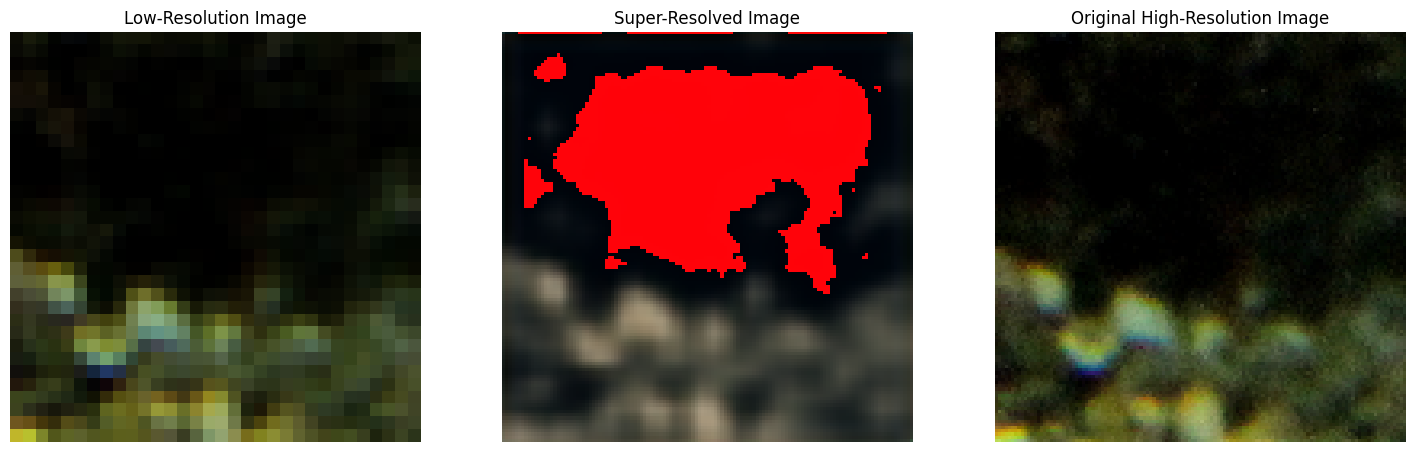

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


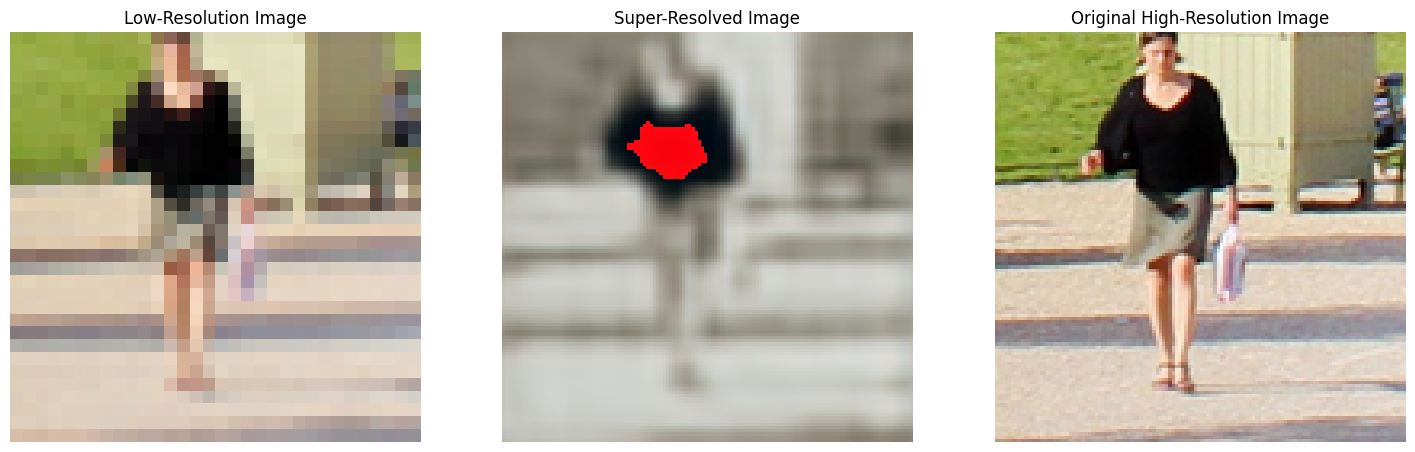

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


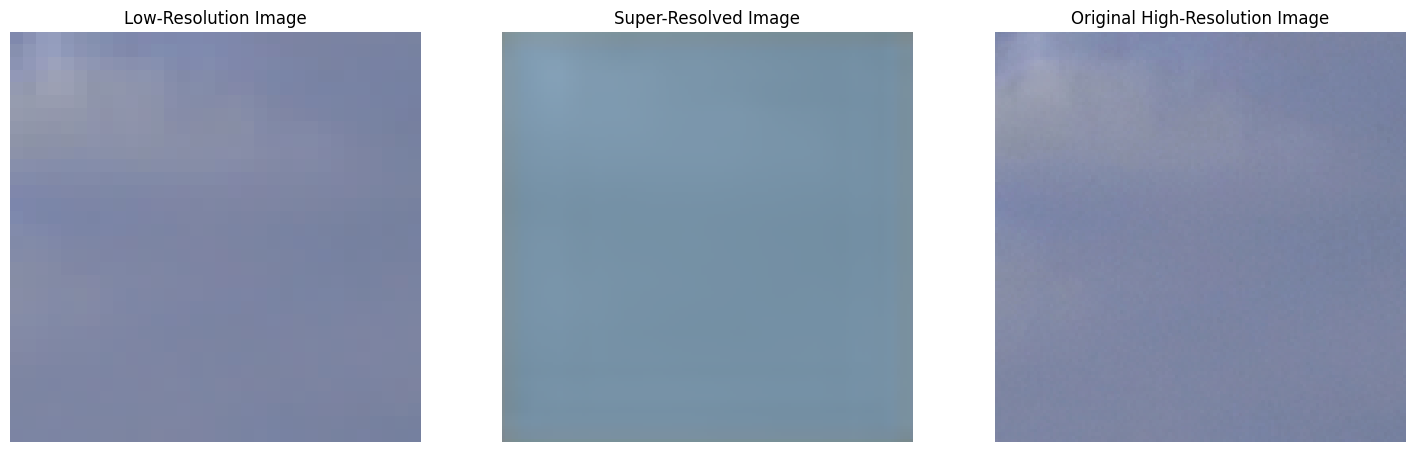

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


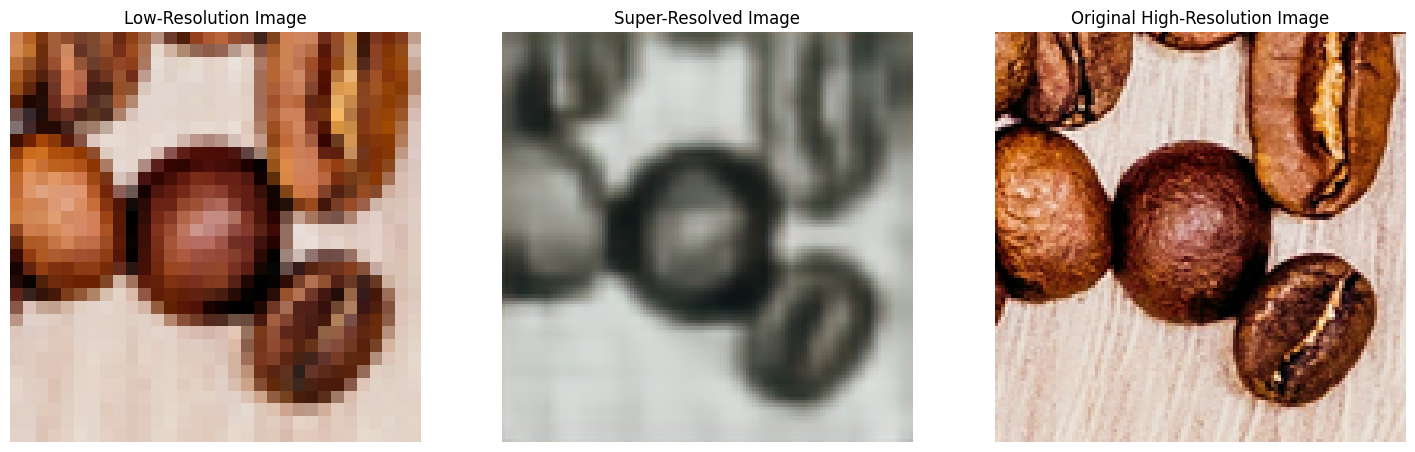

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


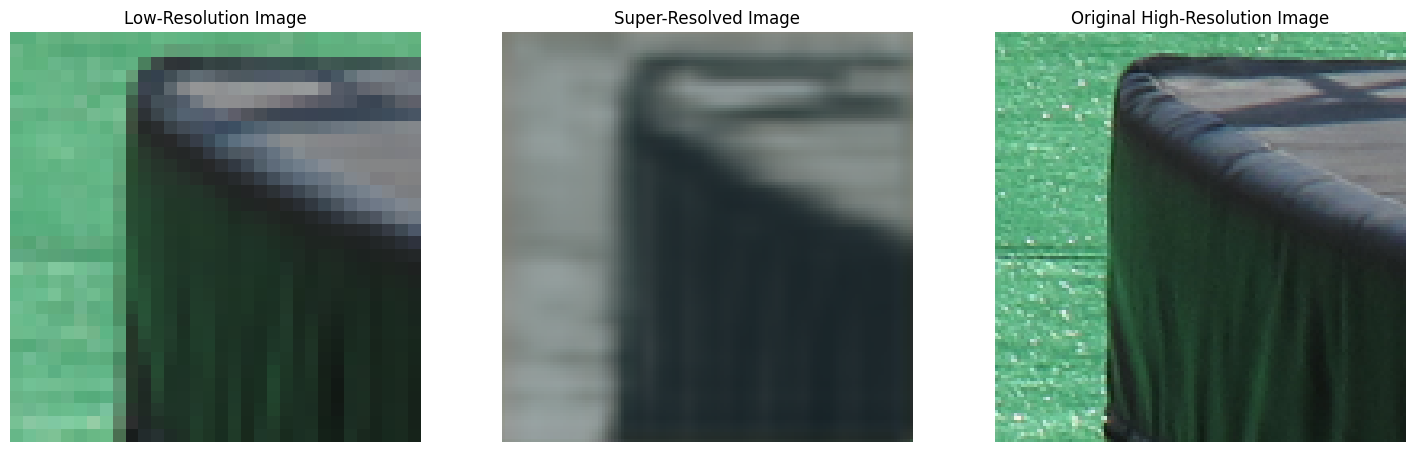

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


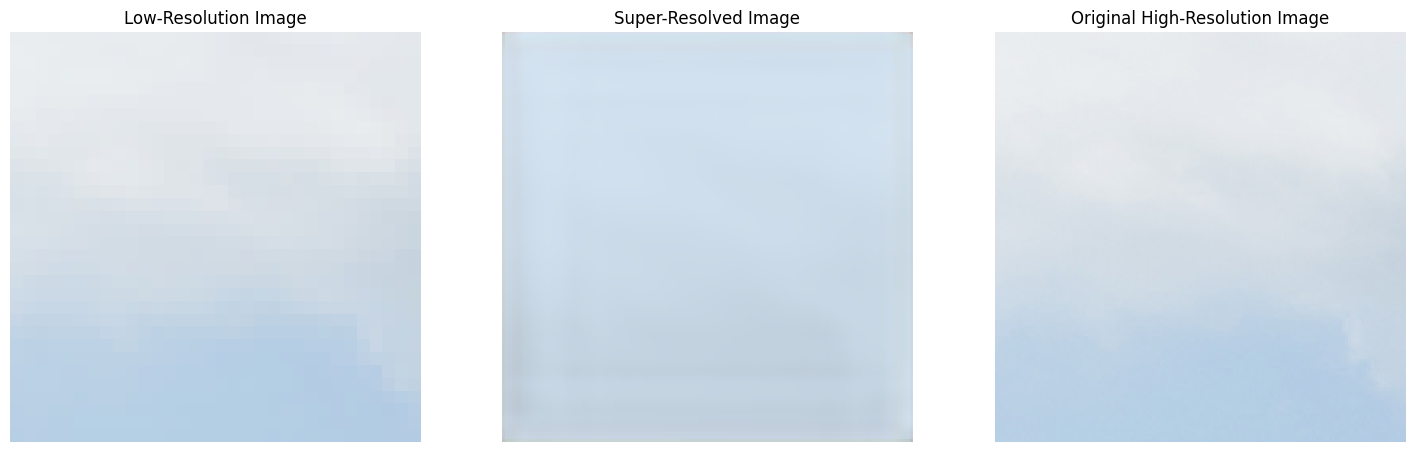

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


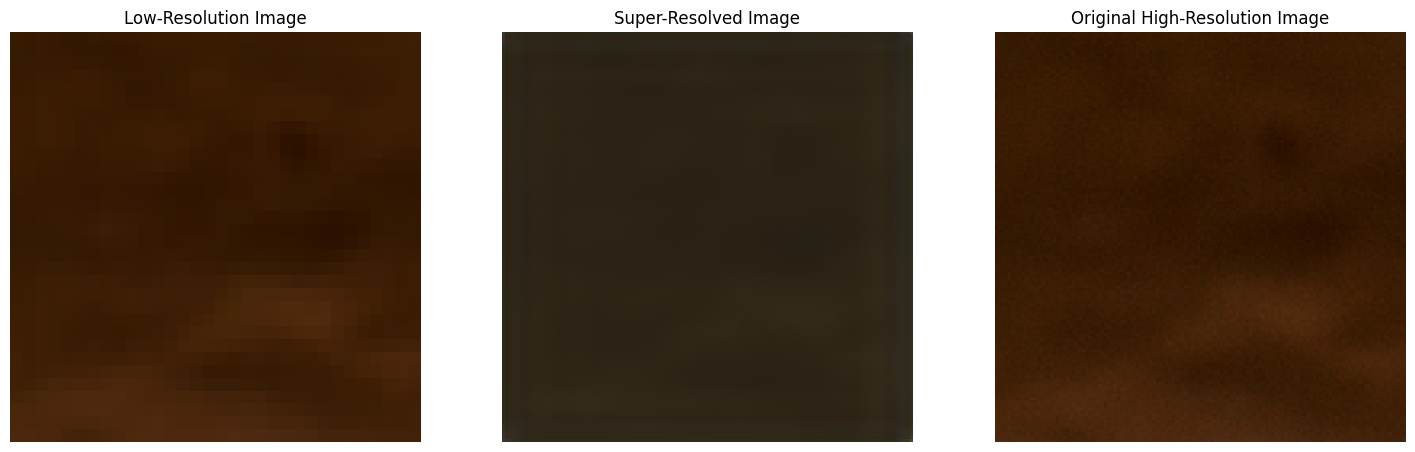

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


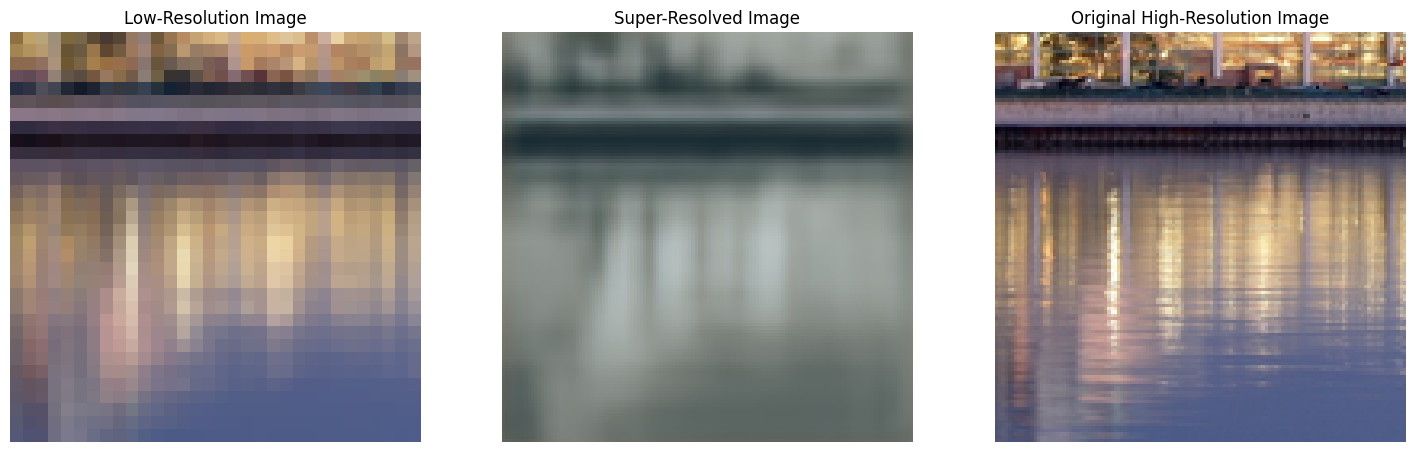

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


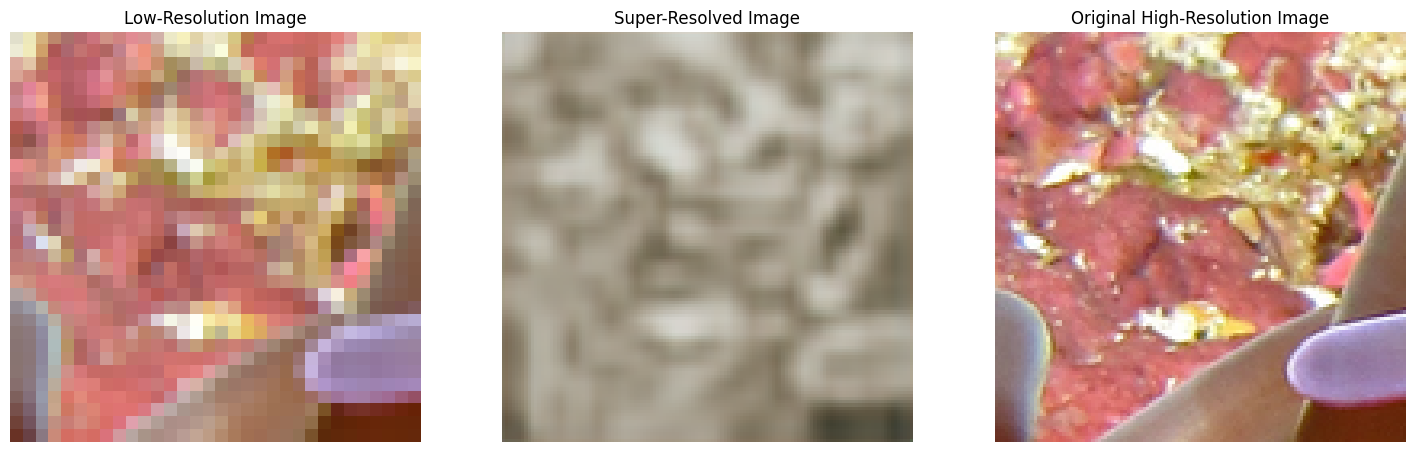

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


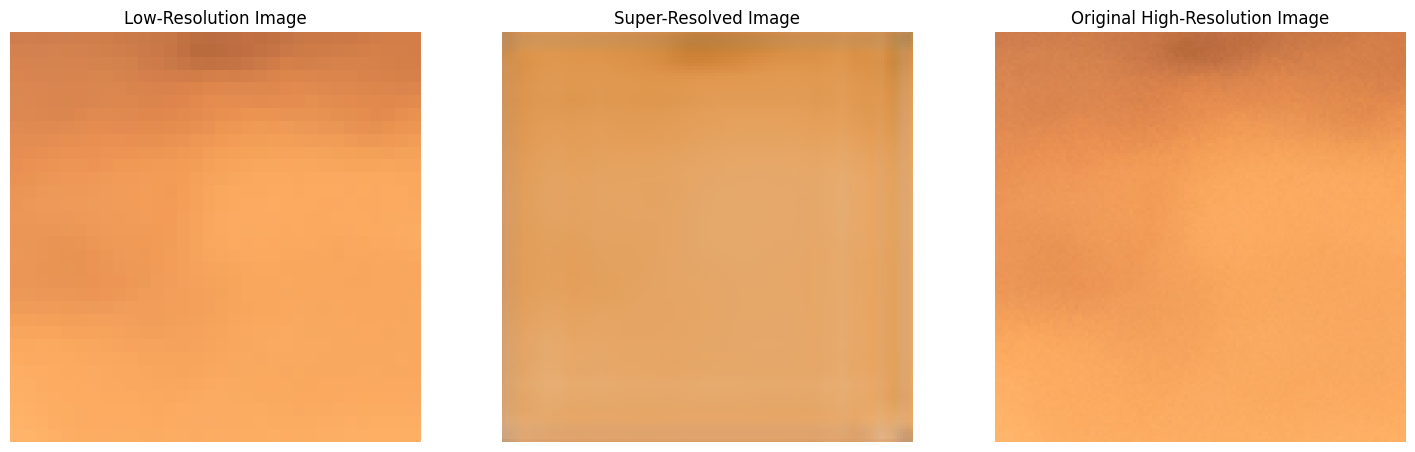

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


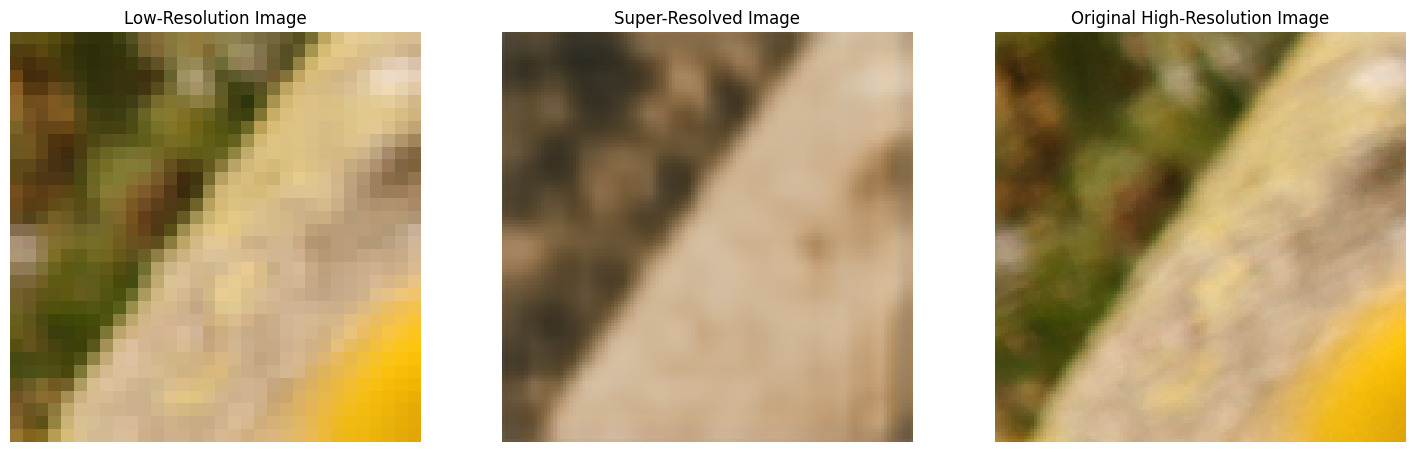

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


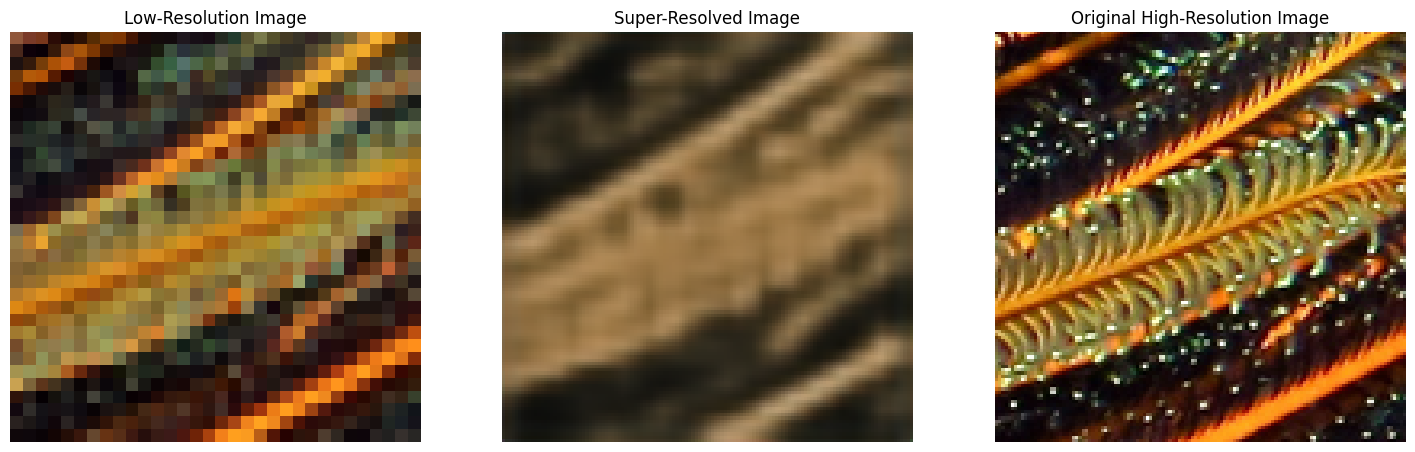

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


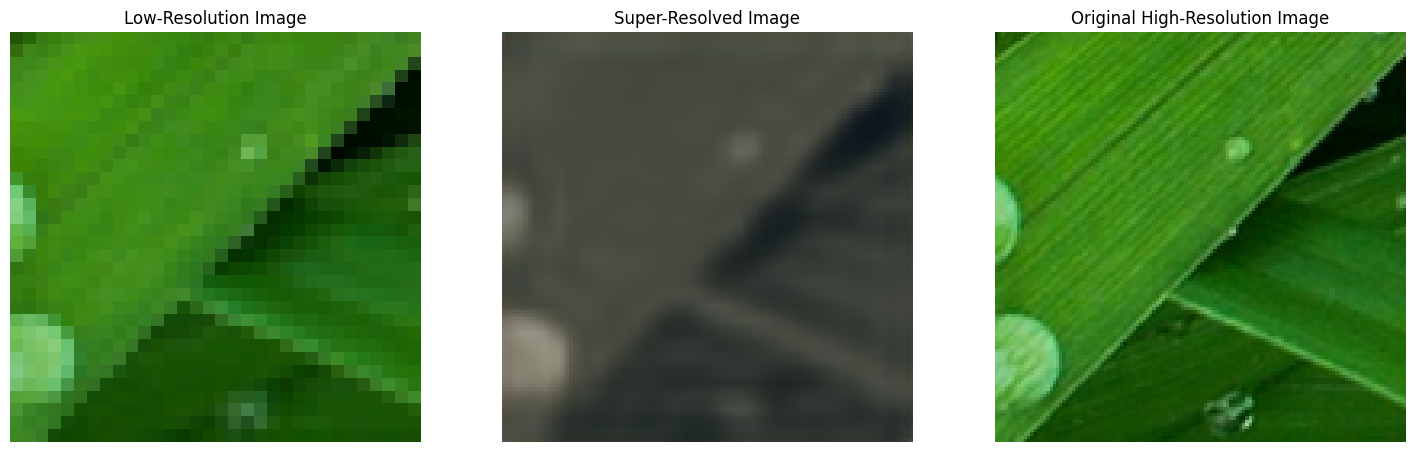

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


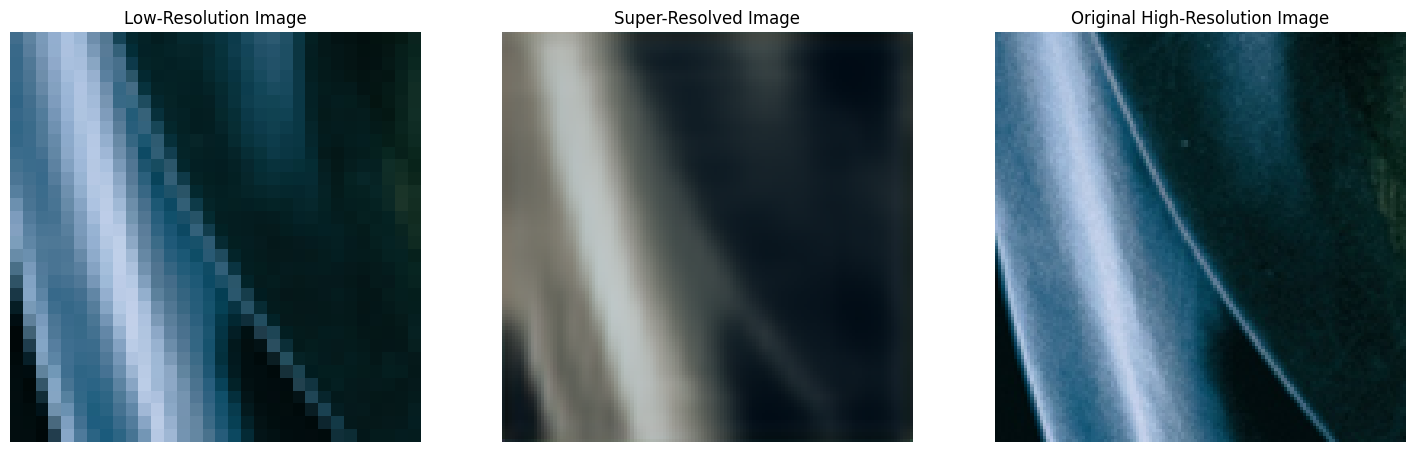

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


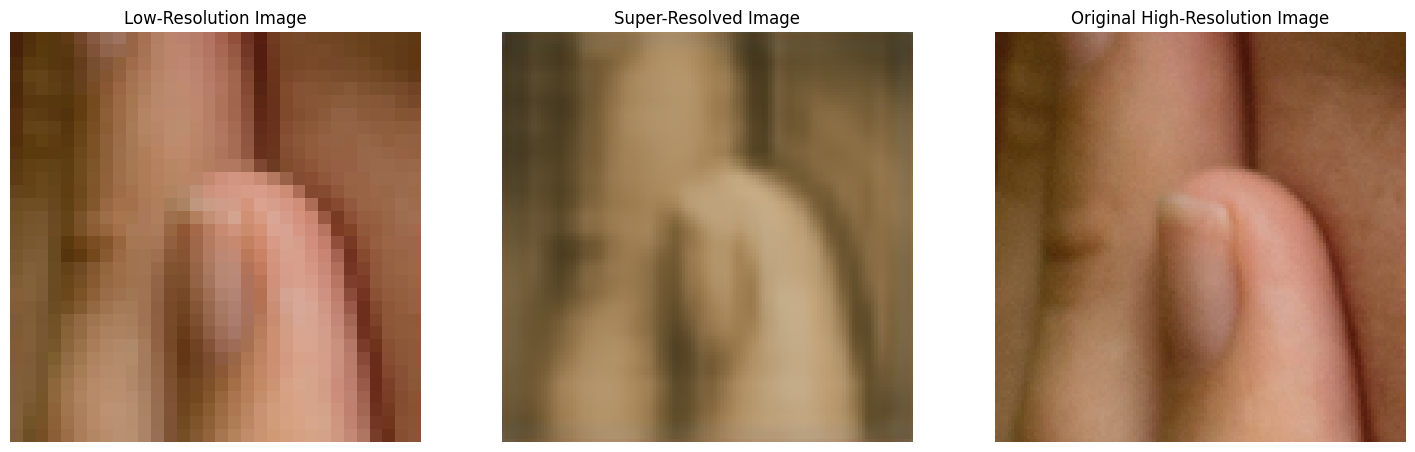

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


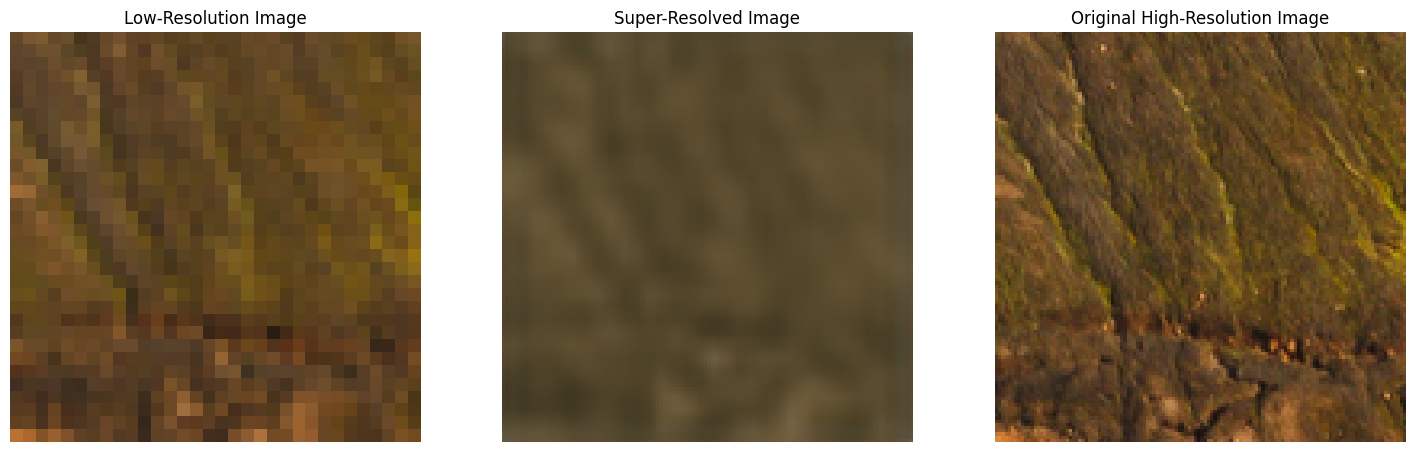

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


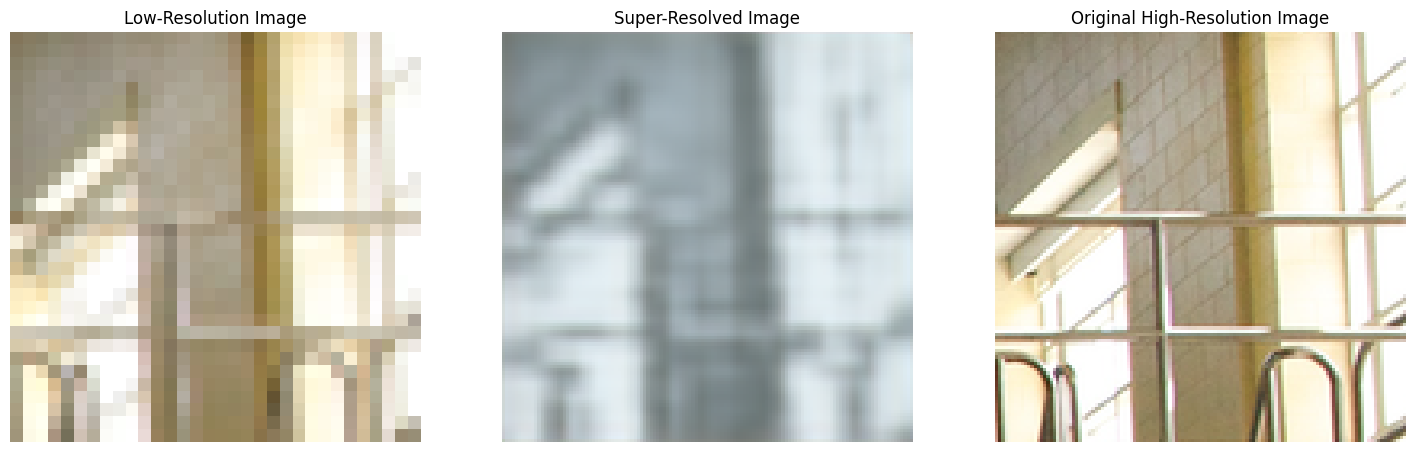

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


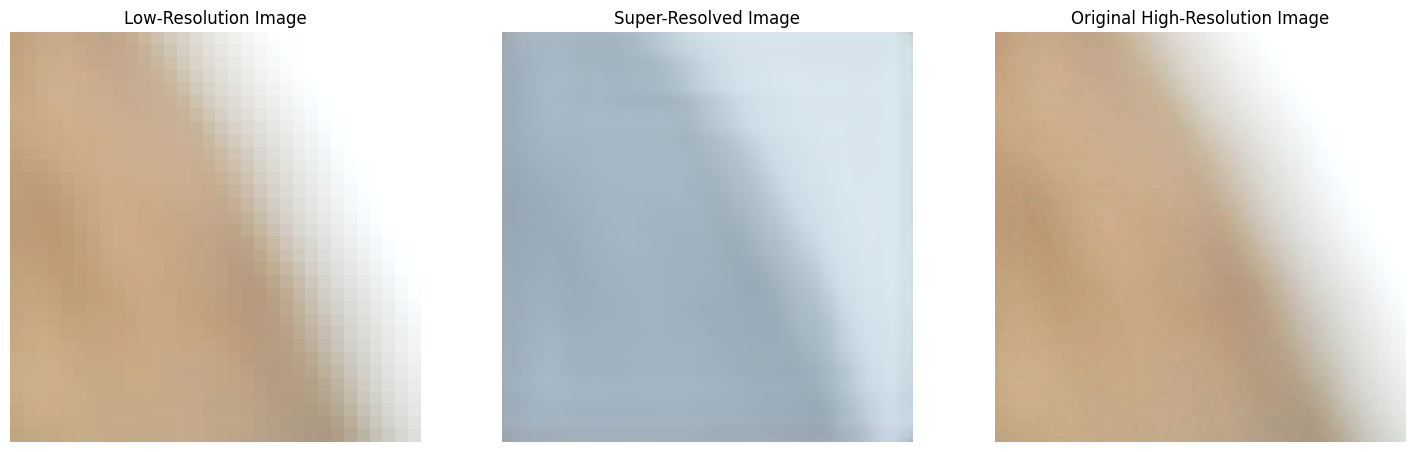

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


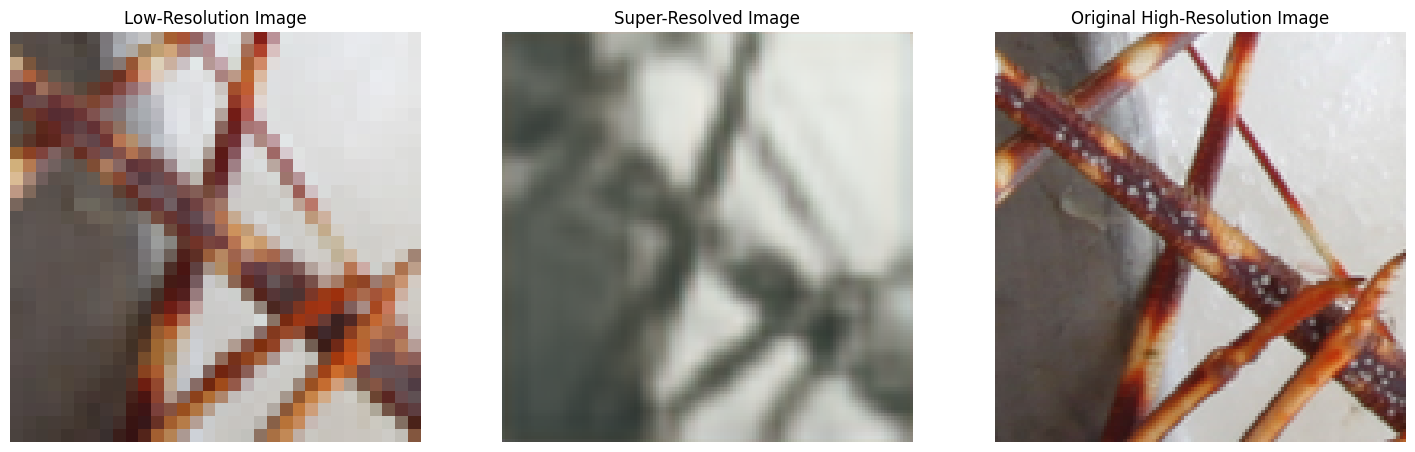

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


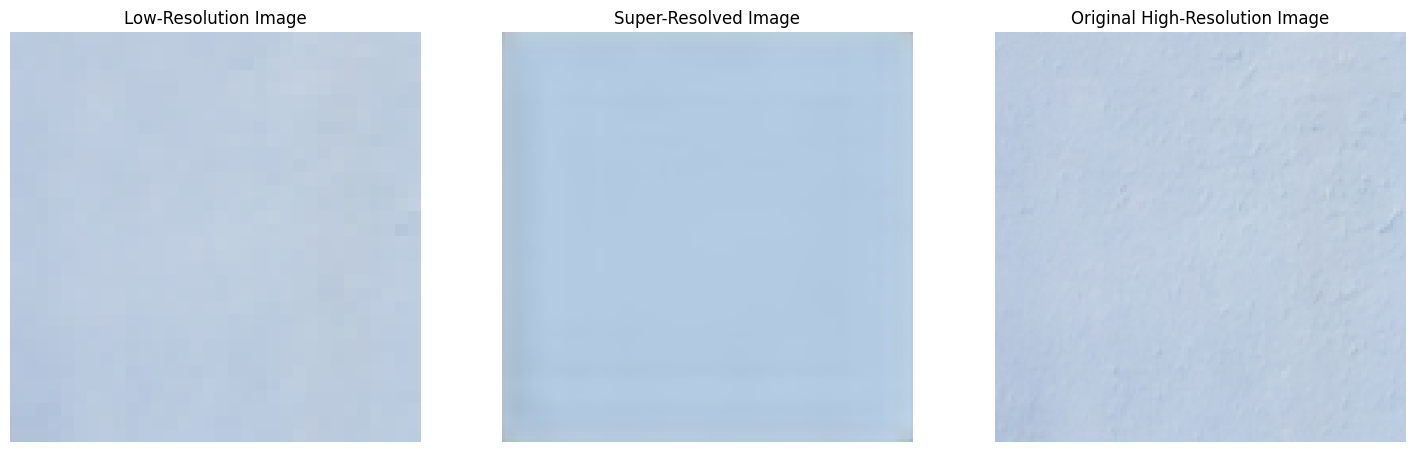

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


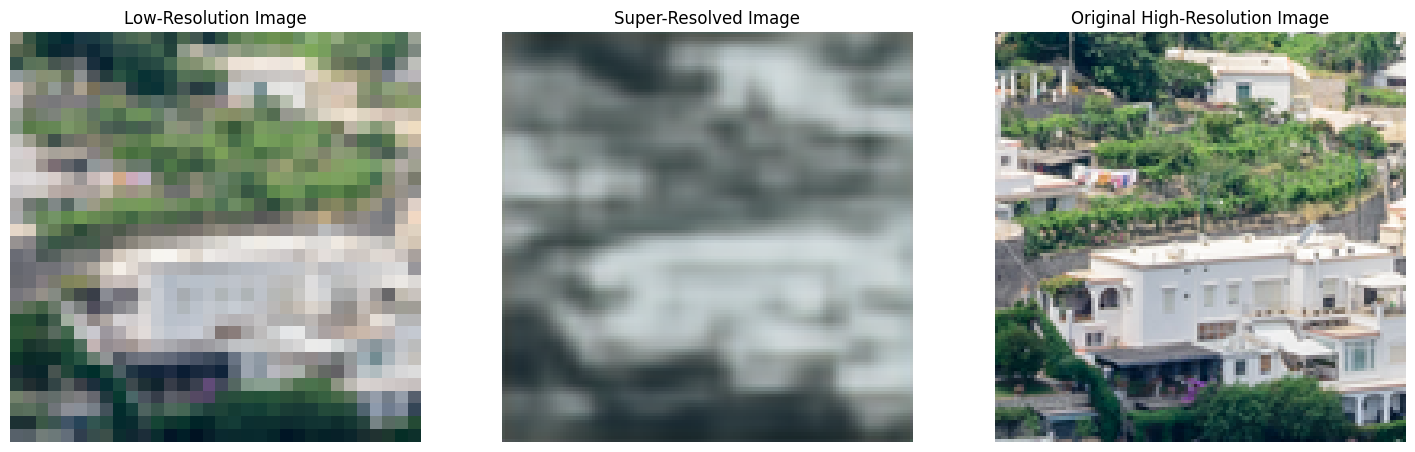

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


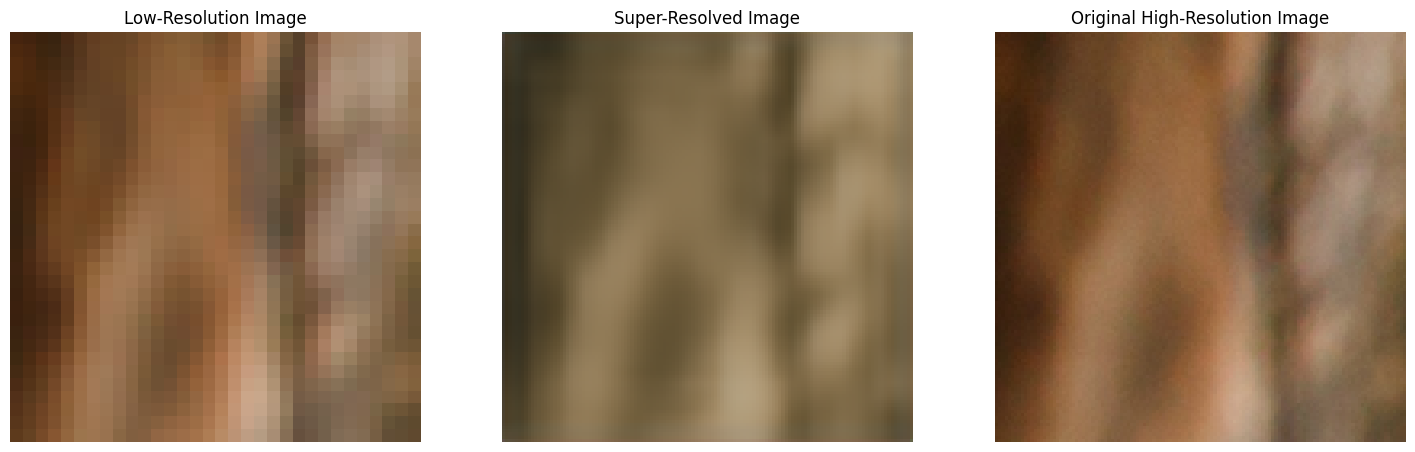

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


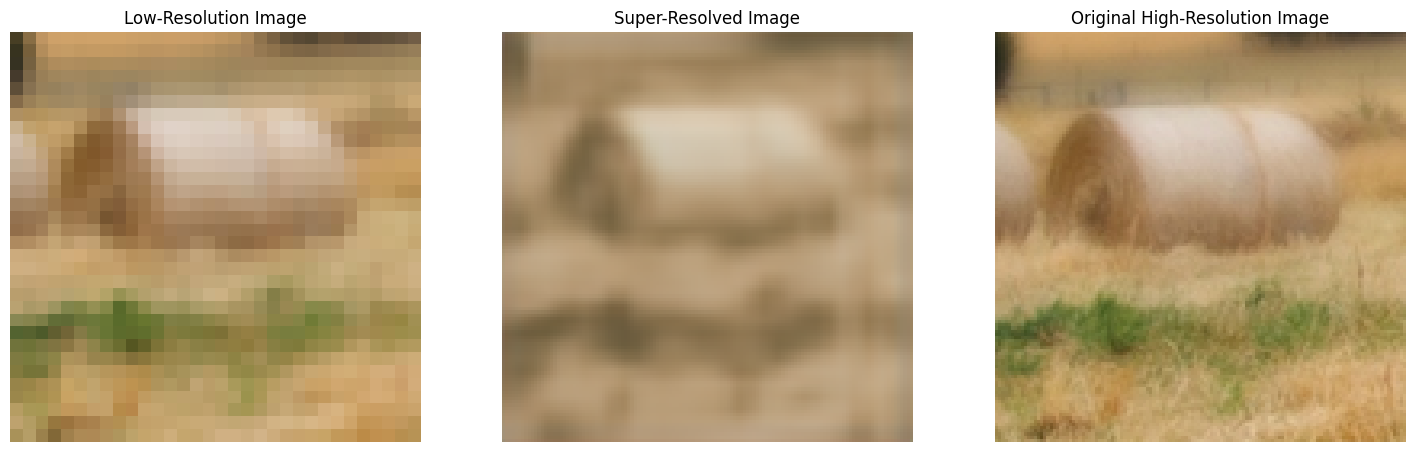

The size of the High-res id: (128, 128)
The size of the Trained-res id: (128, 128)
The size of the Low-res id: (32, 32)


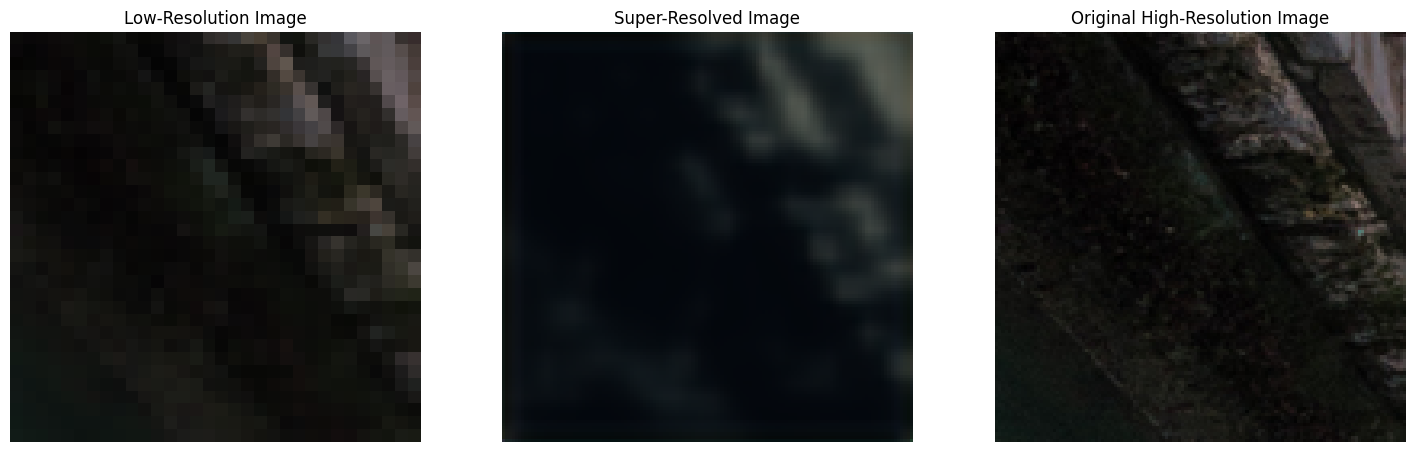

In [51]:
def display_comparison(model, test_loader, device='mps', num_images=3):
    # Set the model to evaluation mode
    model.eval()

    # Define an inverse transform to undo normalization
    inverse_transform = T.Compose([
        T.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        T.ToPILImage()
    ])

    # Process the first few images from the test loader
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(test_loader):
            if i >= num_images:
                break

            # Move images to the appropriate device
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            # Generate the super-resolved image using the model
            sr_imgs = model(lr_imgs)

            # Loop through the batch
            for j in range(lr_imgs.size(0)):
                # Get the images
                lr_image = lr_imgs[j].cpu()
                sr_image = sr_imgs[j].cpu()
                hr_image = hr_imgs[j].cpu()

                # Undo normalization and convert back to PIL
                lr_image_pil = inverse_transform(lr_image)
                sr_image_pil = inverse_transform(sr_image)
                hr_image_pil = inverse_transform(hr_image)
                print(f'The size of the High-res id: {hr_image_pil.size}')
                print(f'The size of the Trained-res id: {sr_image_pil.size}')
                print(f'The size of the Low-res id: {lr_image_pil.size}')
                # Display the images side by side
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.title('Low-Resolution Image')
                plt.imshow(lr_image_pil)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title('Super-Resolved Image')
                plt.imshow(sr_image_pil)
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title('Original High-Resolution Image')
                plt.imshow(hr_image_pil)
                plt.axis('off')

                plt.show()

# Example usage:
display_comparison(model, test_loader, device=device, num_images=3)